01

2023-07-11 16:14:09.110807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/190
Epoch 2/190
Epoch 3/190
Epoch 4/190
Epoch 5/190
Epoch 6/190
Epoch 7/190
Epoch 8/190
Epoch 9/190
Epoch 10/190
Epoch 11/190
Epoch 12/190
Epoch 13/190
Epoch 14/190
Epoch 15/190
Epoch 16/190
Epoch 17/190
Epoch 18/190
Epoch 19/190
Epoch 20/190
Epoch 21/190
Epoch 22/190
Epoch 23/190
Epoch 24/190
Epoch 25/190
Epoch 26/190
Epoch 27/190
Epoch 28/190
Epoch 29/190
Epoch 30/190
Epoch 31/190
Epoch 32/190
Epoch 33/190
Epoch 34/190
Epoch 35/190
Epoch 36/190
Epoch 37/190
Epoch 38/190
Epoch 39/190
Epoch 40/190
Epoch 41/190
Epoch 42/190
Epoch 43/190
Epoch 44/190
Epoch 45/190
Epoch 46/190
Epoch 47/190
Epoch 48/190
Epoch 49/190
Epoch 50/190
Epoch 51/190
Epoch 52/190
Epoch 53/190
Epoch 54/190
Epoch 55/190
Epoch 56/190
Epoch 57/190
Epoch 58/190
Epoch 59/190
Epoch 60/190
Epoch 61/190
Epoch 62/190
Epoch 63/190
Epoch 64/190
Epoch 65/190
Epoch 66/190
Epoch 67/190
Epoch 68/190
Epoch 69/190
Epoch 70/190
Epoch 71/190
Epoch 72/190
Epoch 73/190
Epoch 74/190
Epoch 75/190
Epoch 76/190
Epoch 77/190
Epoch 78

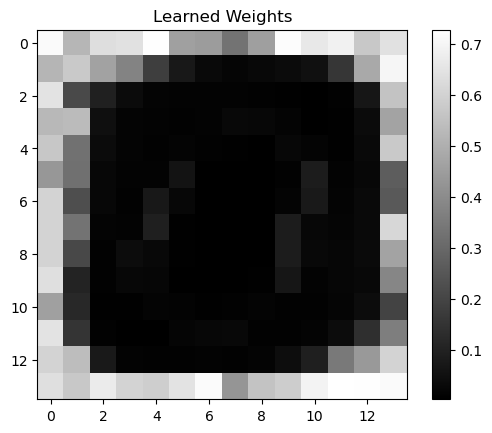

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 0, 1, 0)
y_test_zero = np.where(y_test == 0, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 190
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights01 = positive_weights

Classification accuracy on 10 random samples using weight map: 80.00%


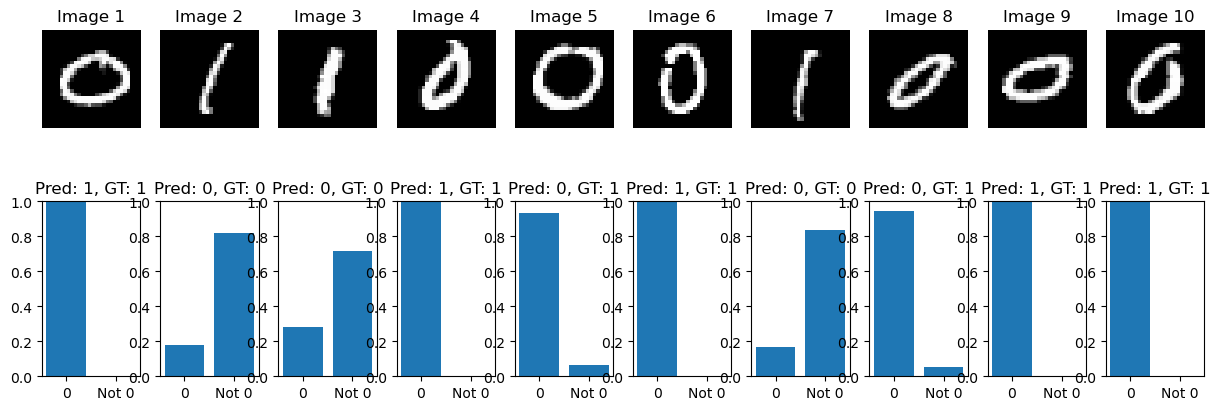

In [2]:
num_samples = 10

train_filter = np.where((y_train == 0) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 0, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights01)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

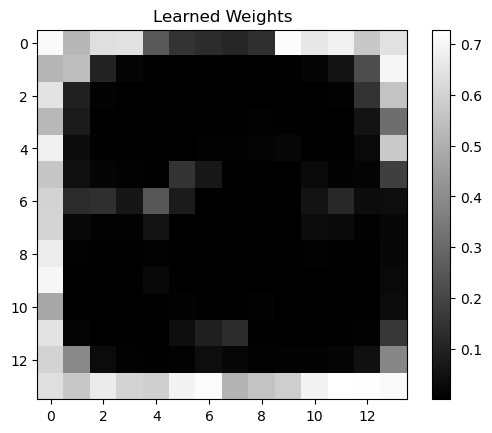

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 2))
test_filter = np.where((y_test == 0) | (y_test == 2))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 0, 1, 0)
y_test_zero = np.where(y_test == 0, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 500
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights02 = positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


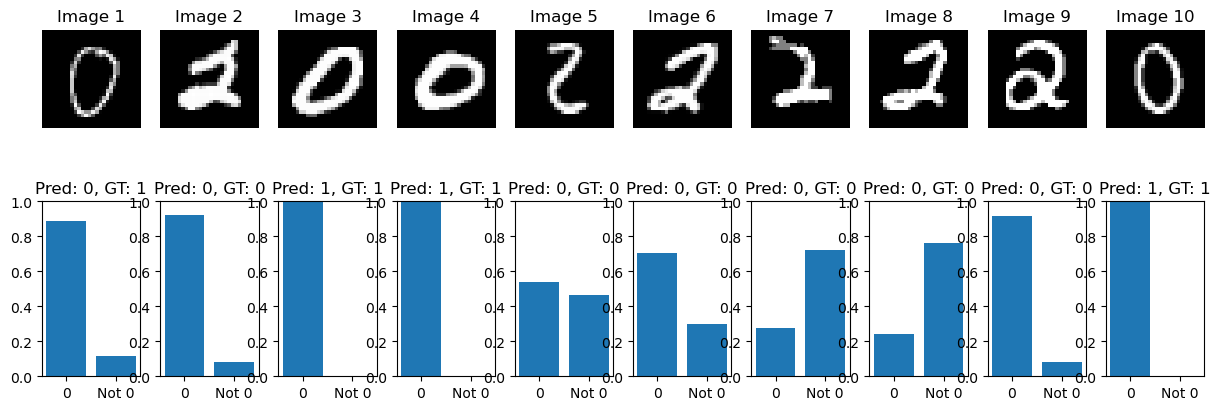

In [4]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 2))
test_filter = np.where((y_test == 0) | (y_test == 2))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 0, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights02)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/290
Epoch 2/290
Epoch 3/290
Epoch 4/290
Epoch 5/290
Epoch 6/290
Epoch 7/290
Epoch 8/290
Epoch 9/290
Epoch 10/290
Epoch 11/290
Epoch 12/290
Epoch 13/290
Epoch 14/290
Epoch 15/290
Epoch 16/290
Epoch 17/290
Epoch 18/290
Epoch 19/290
Epoch 20/290
Epoch 21/290
Epoch 22/290
Epoch 23/290
Epoch 24/290
Epoch 25/290
Epoch 26/290
Epoch 27/290
Epoch 28/290
Epoch 29/290
Epoch 30/290
Epoch 31/290
Epoch 32/290
Epoch 33/290
Epoch 34/290
Epoch 35/290
Epoch 36/290
Epoch 37/290
Epoch 38/290
Epoch 39/290
Epoch 40/290
Epoch 41/290
Epoch 42/290
Epoch 43/290
Epoch 44/290
Epoch 45/290
Epoch 46/290
Epoch 47/290
Epoch 48/290
Epoch 49/290
Epoch 50/290
Epoch 51/290
Epoch 52/290
Epoch 53/290
Epoch 54/290
Epoch 55/290
Epoch 56/290
Epoch 57/290
Epoch 58/290
Epoch 59/290
Epoch 60/290
Epoch 61/290
Epoch 62/290
Epoch 63/290
Epoch 64/290
Epoch 65/290
Epoch 66/290
Epoch 67/290
Epoch 68/290
Epoch 69/290
Epoch 70/290
Epoch 71/290
Epoch 72/290
Epoch 73/290
Epoch 74/290
Epoch 75/290
Epoch 76/290
Epoch 77/290
Epoch 78

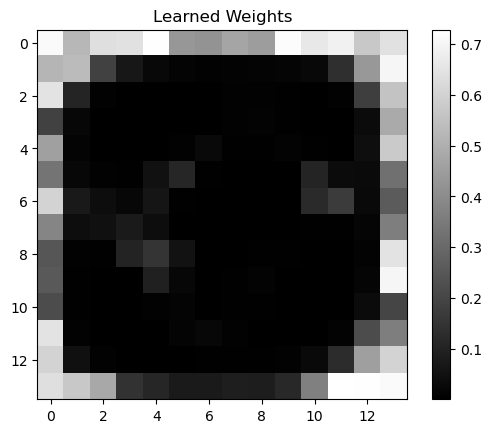

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 3))
test_filter = np.where((y_test == 0) | (y_test == 3))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 0, 1, 0)
y_test_zero = np.where(y_test == 0, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 290
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights03 = positive_weights

Classification accuracy on 10 random samples using weight map: 70.00%


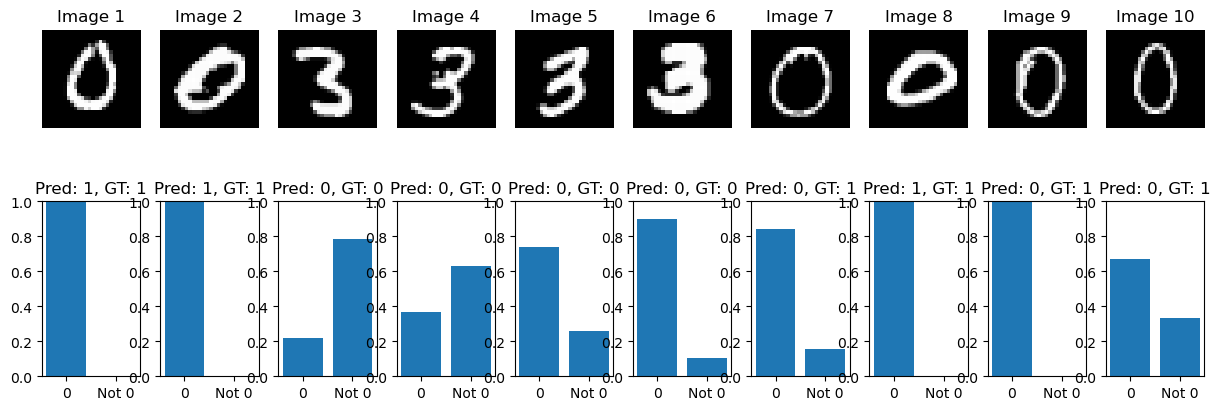

In [6]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 3))
test_filter = np.where((y_test == 0) | (y_test == 3))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 0, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights03)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/190
Epoch 2/190
Epoch 3/190
Epoch 4/190
Epoch 5/190
Epoch 6/190
Epoch 7/190
Epoch 8/190
Epoch 9/190
Epoch 10/190
Epoch 11/190
Epoch 12/190
Epoch 13/190
Epoch 14/190
Epoch 15/190
Epoch 16/190
Epoch 17/190
Epoch 18/190
Epoch 19/190
Epoch 20/190
Epoch 21/190
Epoch 22/190
Epoch 23/190
Epoch 24/190
Epoch 25/190
Epoch 26/190
Epoch 27/190
Epoch 28/190
Epoch 29/190
Epoch 30/190
Epoch 31/190
Epoch 32/190
Epoch 33/190
Epoch 34/190
Epoch 35/190
Epoch 36/190
Epoch 37/190
Epoch 38/190
Epoch 39/190
Epoch 40/190
Epoch 41/190
Epoch 42/190
Epoch 43/190
Epoch 44/190
Epoch 45/190
Epoch 46/190
Epoch 47/190
Epoch 48/190
Epoch 49/190
Epoch 50/190
Epoch 51/190
Epoch 52/190
Epoch 53/190
Epoch 54/190
Epoch 55/190
Epoch 56/190
Epoch 57/190
Epoch 58/190
Epoch 59/190
Epoch 60/190
Epoch 61/190
Epoch 62/190
Epoch 63/190
Epoch 64/190
Epoch 65/190
Epoch 66/190
Epoch 67/190
Epoch 68/190
Epoch 69/190
Epoch 70/190
Epoch 71/190
Epoch 72/190
Epoch 73/190
Epoch 74/190
Epoch 75/190
Epoch 76/190
Epoch 77/190
Epoch 78

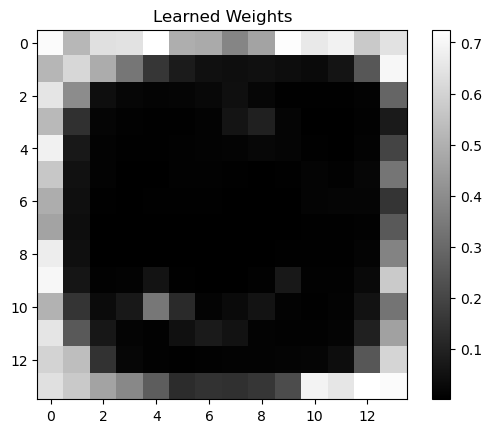

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes



class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 4))
test_filter = np.where((y_test == 0) | (y_test == 4))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 0, 1, 0)
y_test_zero = np.where(y_test == 0, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 190
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights04 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


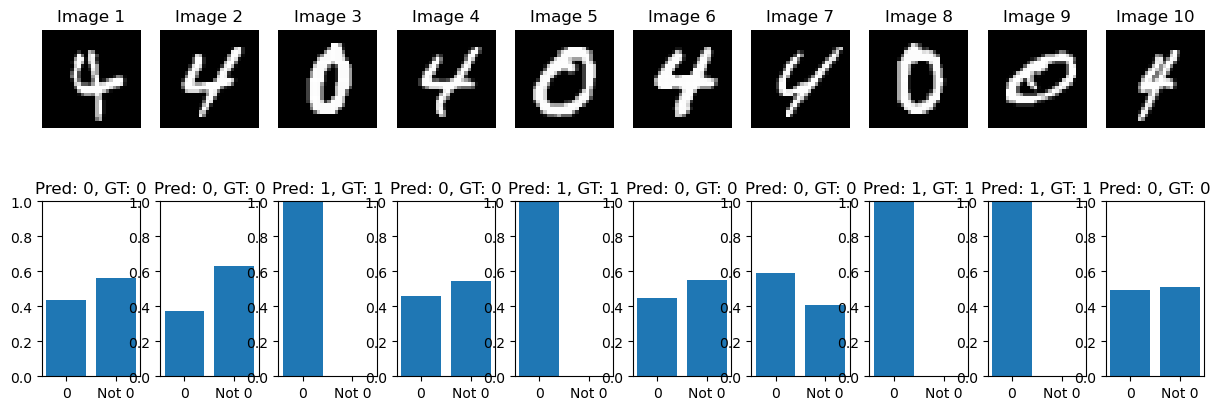

In [8]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 4))
test_filter = np.where((y_test == 0) | (y_test == 4))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 0, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights04)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/190
Epoch 2/190
Epoch 3/190
Epoch 4/190
Epoch 5/190
Epoch 6/190
Epoch 7/190
Epoch 8/190
Epoch 9/190
Epoch 10/190
Epoch 11/190
Epoch 12/190
Epoch 13/190
Epoch 14/190
Epoch 15/190
Epoch 16/190
Epoch 17/190
Epoch 18/190
Epoch 19/190
Epoch 20/190
Epoch 21/190
Epoch 22/190
Epoch 23/190
Epoch 24/190
Epoch 25/190
Epoch 26/190
Epoch 27/190
Epoch 28/190
Epoch 29/190
Epoch 30/190
Epoch 31/190
Epoch 32/190
Epoch 33/190
Epoch 34/190
Epoch 35/190
Epoch 36/190
Epoch 37/190
Epoch 38/190
Epoch 39/190
Epoch 40/190
Epoch 41/190
Epoch 42/190
Epoch 43/190
Epoch 44/190
Epoch 45/190
Epoch 46/190
Epoch 47/190
Epoch 48/190
Epoch 49/190
Epoch 50/190
Epoch 51/190
Epoch 52/190
Epoch 53/190
Epoch 54/190
Epoch 55/190
Epoch 56/190
Epoch 57/190
Epoch 58/190
Epoch 59/190
Epoch 60/190
Epoch 61/190
Epoch 62/190
Epoch 63/190
Epoch 64/190
Epoch 65/190
Epoch 66/190
Epoch 67/190
Epoch 68/190
Epoch 69/190
Epoch 70/190
Epoch 71/190
Epoch 72/190
Epoch 73/190
Epoch 74/190
Epoch 75/190
Epoch 76/190
Epoch 77/190
Epoch 78

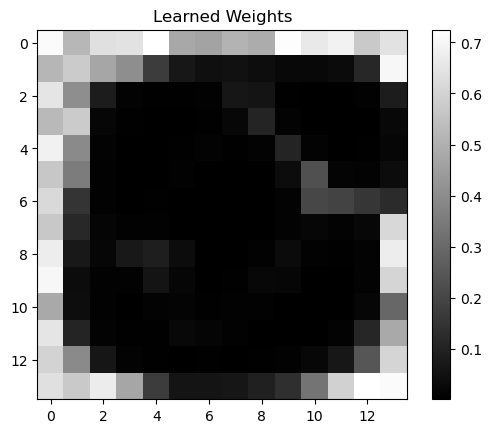

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes



class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 5))
test_filter = np.where((y_test == 0) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 0, 1, 0)
y_test_zero = np.where(y_test == 0, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 190
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights05 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


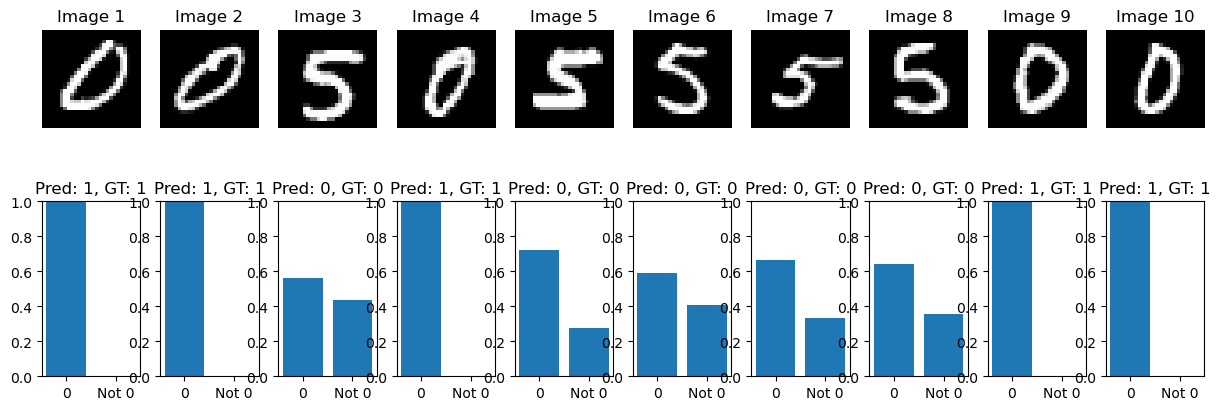

In [10]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 5))
test_filter = np.where((y_test == 0) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 0, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights05)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/290
Epoch 2/290
Epoch 3/290
Epoch 4/290
Epoch 5/290
Epoch 6/290
Epoch 7/290
Epoch 8/290
Epoch 9/290
Epoch 10/290
Epoch 11/290
Epoch 12/290
Epoch 13/290
Epoch 14/290
Epoch 15/290
Epoch 16/290
Epoch 17/290
Epoch 18/290
Epoch 19/290
Epoch 20/290
Epoch 21/290
Epoch 22/290
Epoch 23/290
Epoch 24/290
Epoch 25/290
Epoch 26/290
Epoch 27/290
Epoch 28/290
Epoch 29/290
Epoch 30/290
Epoch 31/290
Epoch 32/290
Epoch 33/290
Epoch 34/290
Epoch 35/290
Epoch 36/290
Epoch 37/290
Epoch 38/290
Epoch 39/290
Epoch 40/290
Epoch 41/290
Epoch 42/290
Epoch 43/290
Epoch 44/290
Epoch 45/290
Epoch 46/290
Epoch 47/290
Epoch 48/290
Epoch 49/290
Epoch 50/290
Epoch 51/290
Epoch 52/290
Epoch 53/290
Epoch 54/290
Epoch 55/290
Epoch 56/290
Epoch 57/290
Epoch 58/290
Epoch 59/290
Epoch 60/290
Epoch 61/290
Epoch 62/290
Epoch 63/290
Epoch 64/290
Epoch 65/290
Epoch 66/290
Epoch 67/290
Epoch 68/290
Epoch 69/290
Epoch 70/290
Epoch 71/290
Epoch 72/290
Epoch 73/290
Epoch 74/290
Epoch 75/290
Epoch 76/290
Epoch 77/290
Epoch 78

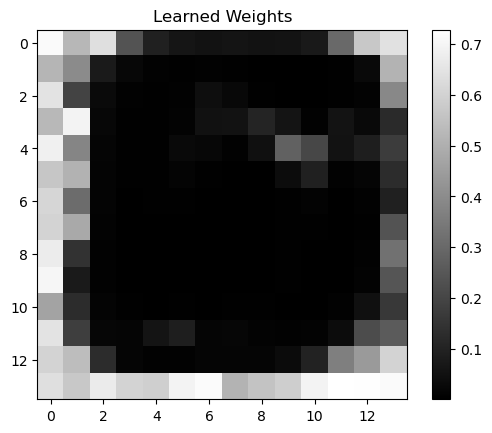

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes



class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 6))
test_filter = np.where((y_test == 0) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 0, 1, 0)
y_test_zero = np.where(y_test == 0, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 290
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights06 = positive_weights

Classification accuracy on 10 random samples using weight map: 60.00%


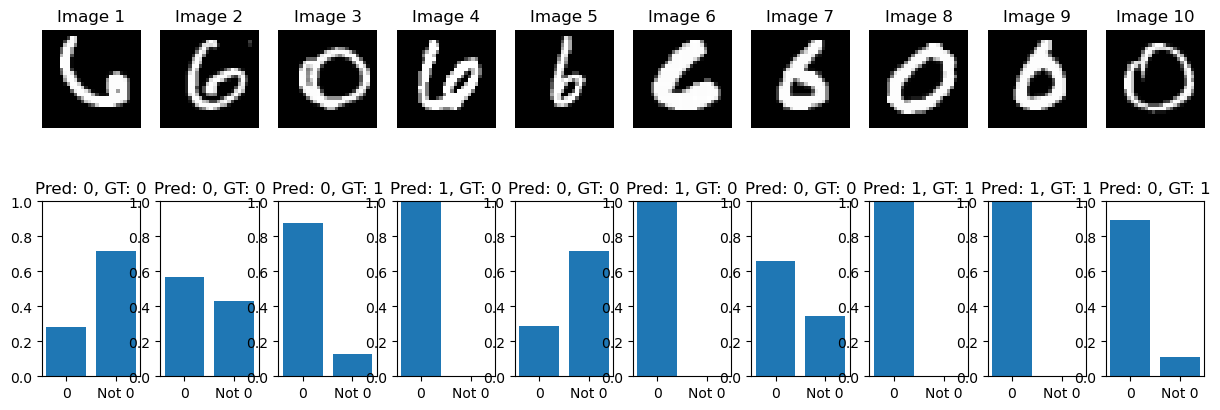

In [12]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 6))
test_filter = np.where((y_test == 0) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 0, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)
predictions = np.dot(x_samples_flat, np_weights06)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/290
Epoch 2/290
Epoch 3/290
Epoch 4/290
Epoch 5/290
Epoch 6/290
Epoch 7/290
Epoch 8/290
Epoch 9/290
Epoch 10/290
Epoch 11/290
Epoch 12/290
Epoch 13/290
Epoch 14/290
Epoch 15/290
Epoch 16/290
Epoch 17/290
Epoch 18/290
Epoch 19/290
Epoch 20/290
Epoch 21/290
Epoch 22/290
Epoch 23/290
Epoch 24/290
Epoch 25/290
Epoch 26/290
Epoch 27/290
Epoch 28/290
Epoch 29/290
Epoch 30/290
Epoch 31/290
Epoch 32/290
Epoch 33/290
Epoch 34/290
Epoch 35/290
Epoch 36/290
Epoch 37/290
Epoch 38/290
Epoch 39/290
Epoch 40/290
Epoch 41/290
Epoch 42/290
Epoch 43/290
Epoch 44/290
Epoch 45/290
Epoch 46/290
Epoch 47/290
Epoch 48/290
Epoch 49/290
Epoch 50/290
Epoch 51/290
Epoch 52/290
Epoch 53/290
Epoch 54/290
Epoch 55/290
Epoch 56/290
Epoch 57/290
Epoch 58/290
Epoch 59/290
Epoch 60/290
Epoch 61/290
Epoch 62/290
Epoch 63/290
Epoch 64/290
Epoch 65/290
Epoch 66/290
Epoch 67/290
Epoch 68/290
Epoch 69/290
Epoch 70/290
Epoch 71/290
Epoch 72/290
Epoch 73/290
Epoch 74/290
Epoch 75/290
Epoch 76/290
Epoch 77/290
Epoch 78

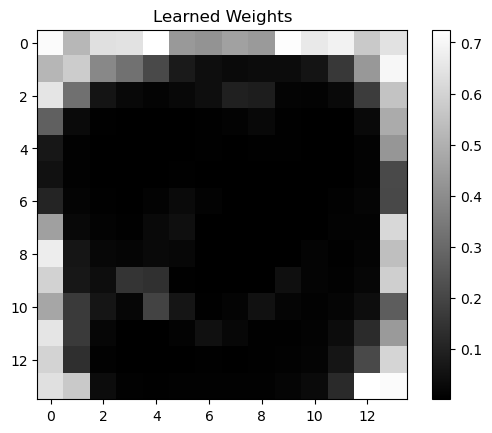

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 7))
test_filter = np.where((y_test == 0) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 0, 1, 0)
y_test_zero = np.where(y_test == 0, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 290
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights07 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


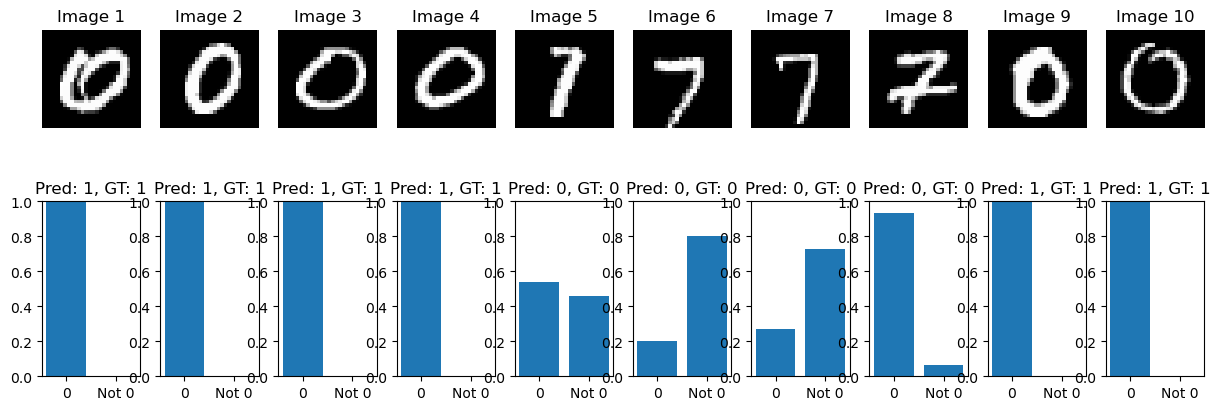

In [14]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 7))
test_filter = np.where((y_test == 0) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 0, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights07)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/490
Epoch 2/490
Epoch 3/490
Epoch 4/490
Epoch 5/490
Epoch 6/490
Epoch 7/490
Epoch 8/490
Epoch 9/490
Epoch 10/490
Epoch 11/490
Epoch 12/490
Epoch 13/490
Epoch 14/490
Epoch 15/490
Epoch 16/490
Epoch 17/490
Epoch 18/490
Epoch 19/490
Epoch 20/490
Epoch 21/490
Epoch 22/490
Epoch 23/490
Epoch 24/490
Epoch 25/490
Epoch 26/490
Epoch 27/490
Epoch 28/490
Epoch 29/490
Epoch 30/490
Epoch 31/490
Epoch 32/490
Epoch 33/490
Epoch 34/490
Epoch 35/490
Epoch 36/490
Epoch 37/490
Epoch 38/490
Epoch 39/490
Epoch 40/490
Epoch 41/490
Epoch 42/490
Epoch 43/490
Epoch 44/490
Epoch 45/490
Epoch 46/490
Epoch 47/490
Epoch 48/490
Epoch 49/490
Epoch 50/490
Epoch 51/490
Epoch 52/490
Epoch 53/490
Epoch 54/490
Epoch 55/490
Epoch 56/490
Epoch 57/490
Epoch 58/490
Epoch 59/490
Epoch 60/490
Epoch 61/490
Epoch 62/490
Epoch 63/490
Epoch 64/490
Epoch 65/490
Epoch 66/490
Epoch 67/490
Epoch 68/490
Epoch 69/490
Epoch 70/490
Epoch 71/490
Epoch 72/490
Epoch 73/490
Epoch 74/490
Epoch 75/490
Epoch 76/490
Epoch 77/490
Epoch 78

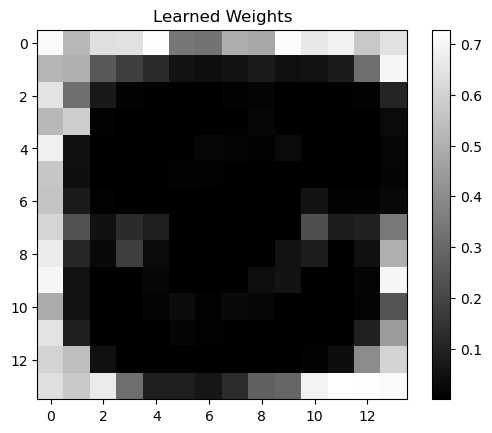

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 8))
test_filter = np.where((y_test == 0) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 0, 1, 0)
y_test_zero = np.where(y_test == 0, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 490
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights08 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


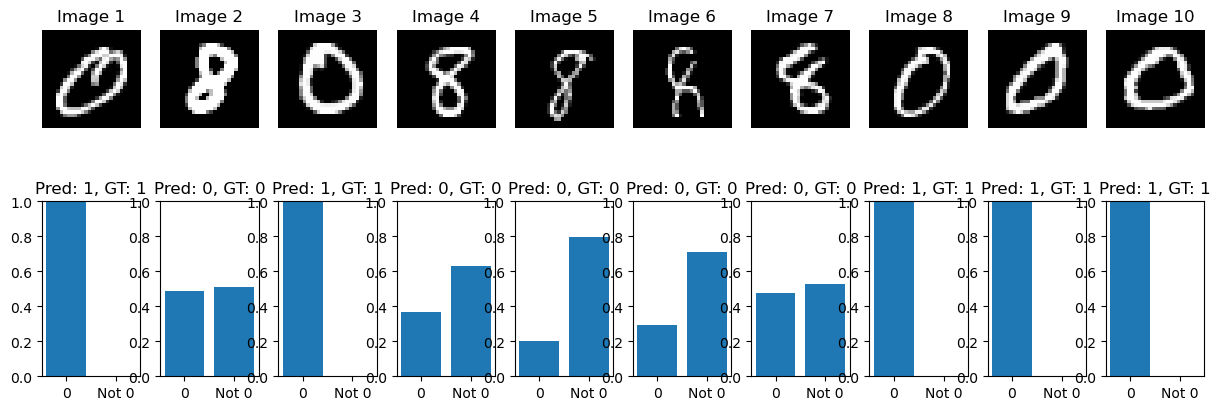

In [16]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 8))
test_filter = np.where((y_test == 0) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 0, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)
predictions = np.dot(x_samples_flat, np_weights08)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/290
Epoch 2/290
Epoch 3/290
Epoch 4/290
Epoch 5/290
Epoch 6/290
Epoch 7/290
Epoch 8/290
Epoch 9/290
Epoch 10/290
Epoch 11/290
Epoch 12/290
Epoch 13/290
Epoch 14/290
Epoch 15/290
Epoch 16/290
Epoch 17/290
Epoch 18/290
Epoch 19/290
Epoch 20/290
Epoch 21/290
Epoch 22/290
Epoch 23/290
Epoch 24/290
Epoch 25/290
Epoch 26/290
Epoch 27/290
Epoch 28/290
Epoch 29/290
Epoch 30/290
Epoch 31/290
Epoch 32/290
Epoch 33/290
Epoch 34/290
Epoch 35/290
Epoch 36/290
Epoch 37/290
Epoch 38/290
Epoch 39/290
Epoch 40/290
Epoch 41/290
Epoch 42/290
Epoch 43/290
Epoch 44/290
Epoch 45/290
Epoch 46/290
Epoch 47/290
Epoch 48/290
Epoch 49/290
Epoch 50/290
Epoch 51/290
Epoch 52/290
Epoch 53/290
Epoch 54/290
Epoch 55/290
Epoch 56/290
Epoch 57/290
Epoch 58/290
Epoch 59/290
Epoch 60/290
Epoch 61/290
Epoch 62/290
Epoch 63/290
Epoch 64/290
Epoch 65/290
Epoch 66/290
Epoch 67/290
Epoch 68/290
Epoch 69/290
Epoch 70/290
Epoch 71/290
Epoch 72/290
Epoch 73/290
Epoch 74/290
Epoch 75/290
Epoch 76/290
Epoch 77/290
Epoch 78

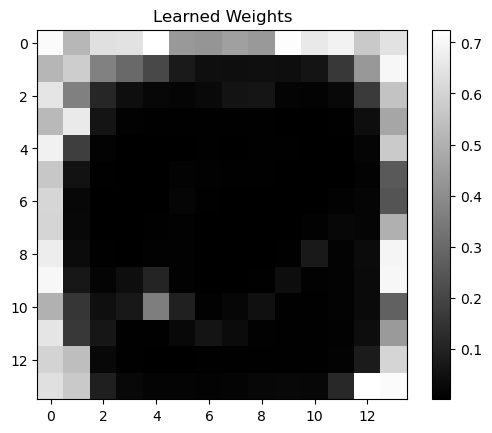

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 9))
test_filter = np.where((y_test == 0) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 0, 1, 0)
y_test_zero = np.where(y_test == 0, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 290
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights09 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


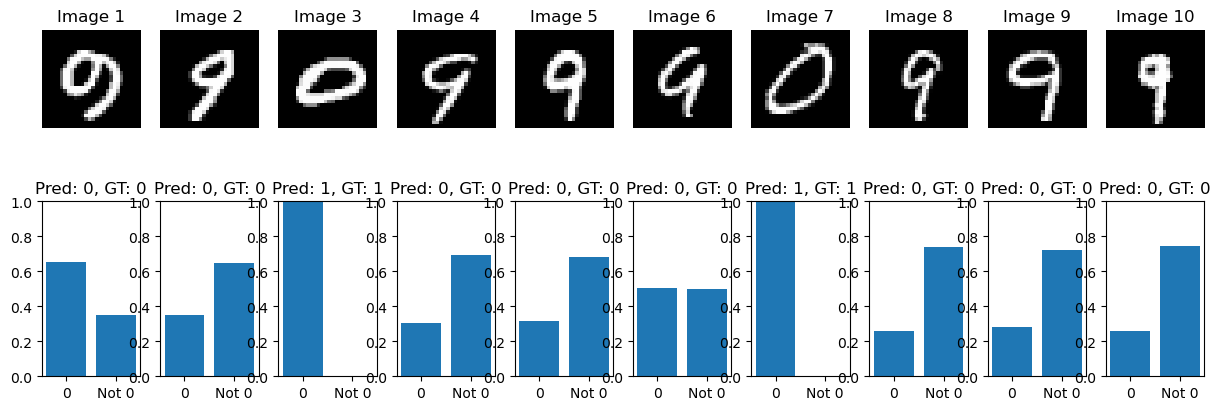

In [18]:
num_samples = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_filter = np.where((y_train == 0) | (y_train == 9))
test_filter = np.where((y_test == 0) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 0, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)
predictions = np.dot(x_samples_flat, np_weights09)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

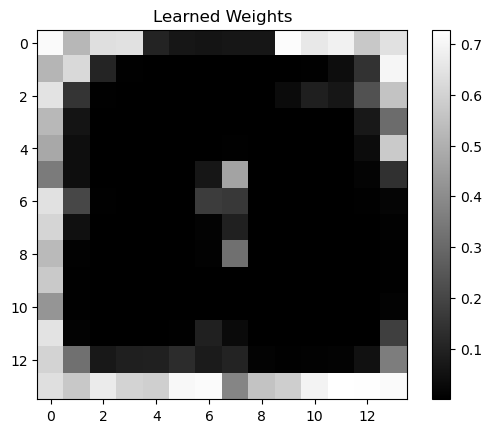

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 2))
test_filter = np.where((y_test == 1) | (y_test == 2))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 1, 1, 0)
y_test_zero = np.where(y_test == 1, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights12 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


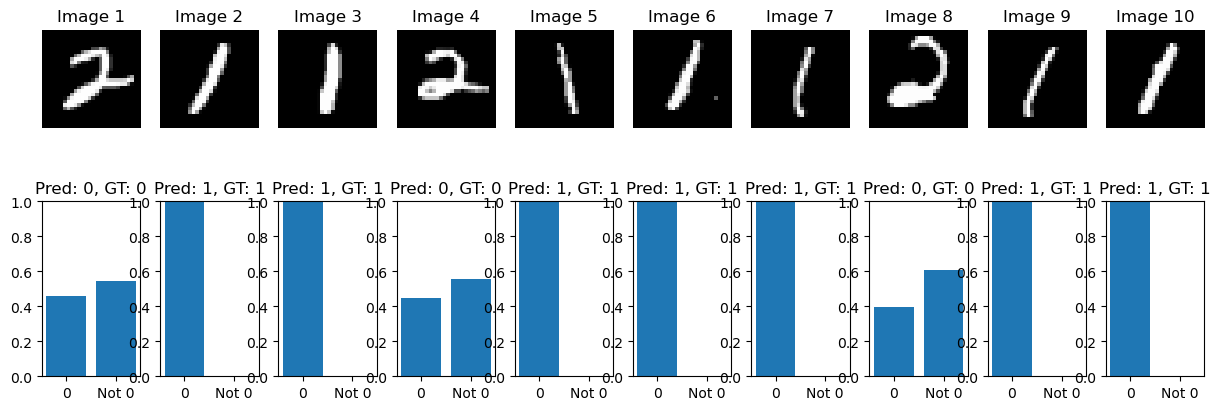

In [20]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 2))
test_filter = np.where((y_test == 1) | (y_test == 2))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 1, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)
predictions = np.dot(x_samples_flat, np_weights12)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

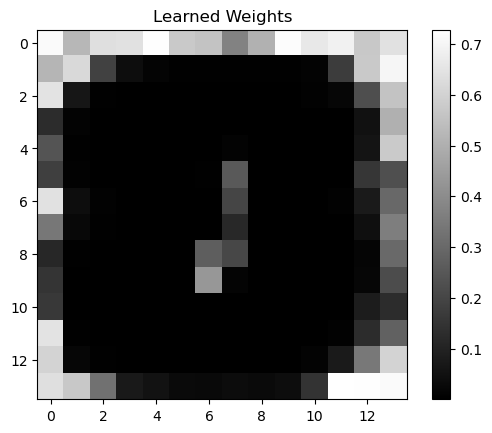

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 3))
test_filter = np.where((y_test == 1) | (y_test == 3))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 1, 1, 0)
y_test_zero = np.where(y_test == 1, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights13 = positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


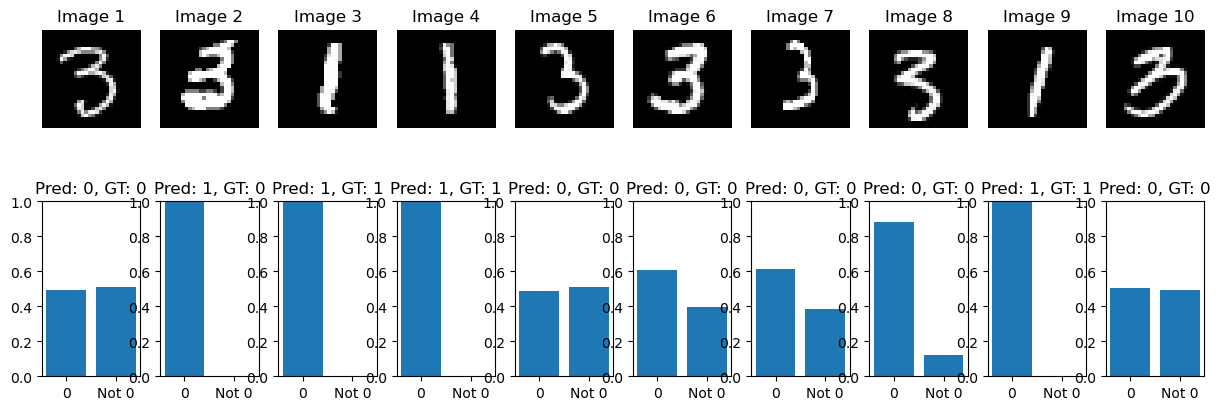

In [22]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 3))
test_filter = np.where((y_test == 1) | (y_test == 3))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 1, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights13)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

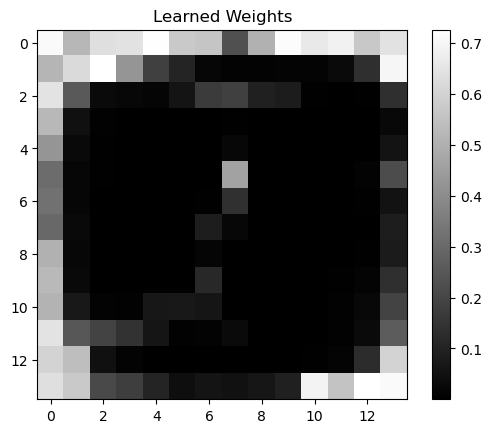

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 4))
test_filter = np.where((y_test == 1) | (y_test == 4))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 1, 1, 0)
y_test_zero = np.where(y_test == 1, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights14 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


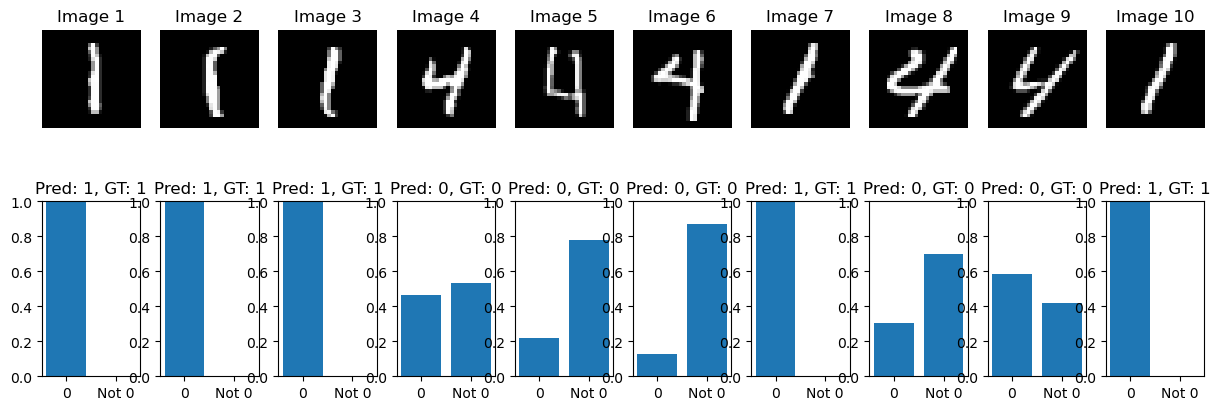

In [24]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 4))
test_filter = np.where((y_test == 1) | (y_test == 4))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 1, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)


predictions = np.dot(x_samples_flat, np_weights14)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

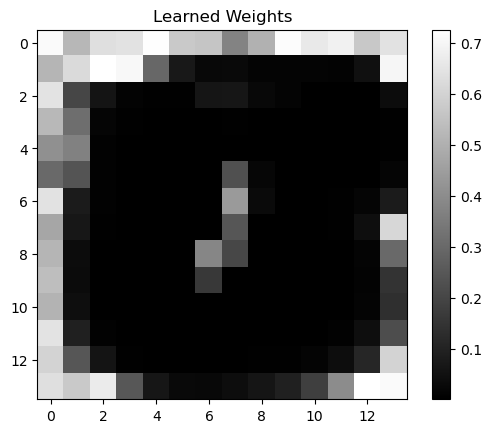

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 5))
test_filter = np.where((y_test == 1) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 1, 1, 0)
y_test_zero = np.where(y_test == 1, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights15 = positive_weights

Classification accuracy on 10 random samples using weight map: 60.00%


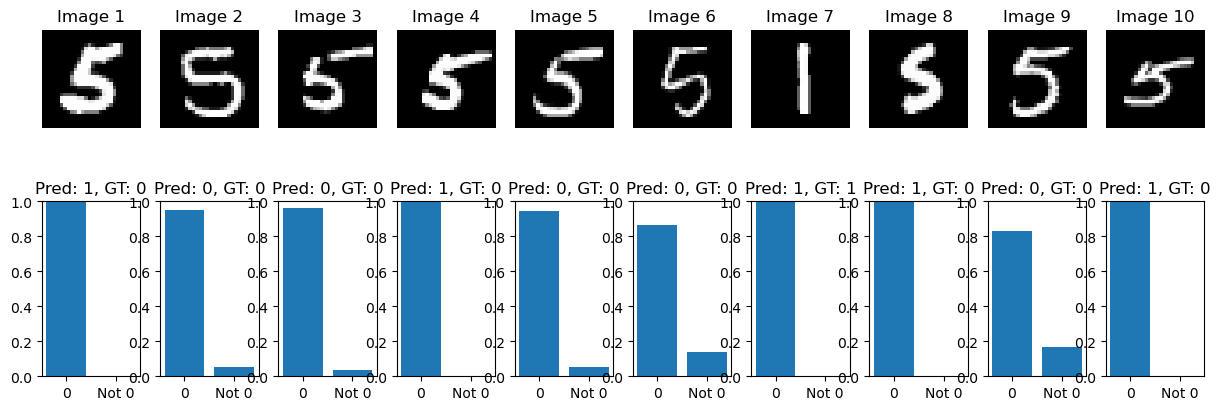

In [26]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 5))
test_filter = np.where((y_test == 1) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 1, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)
predictions = np.dot(x_samples_flat, np_weights15)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

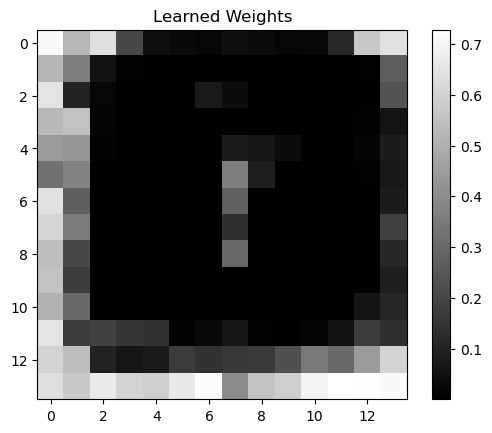

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 6))
test_filter = np.where((y_test == 1) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 1, 1, 0)
y_test_zero = np.where(y_test == 1, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights16 = positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


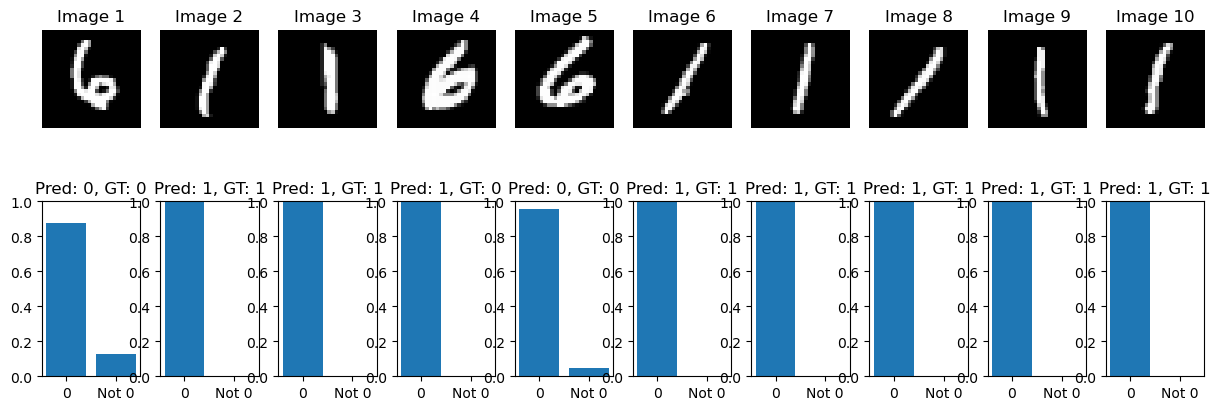

In [28]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 6))
test_filter = np.where((y_test == 1) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 1, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights16)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

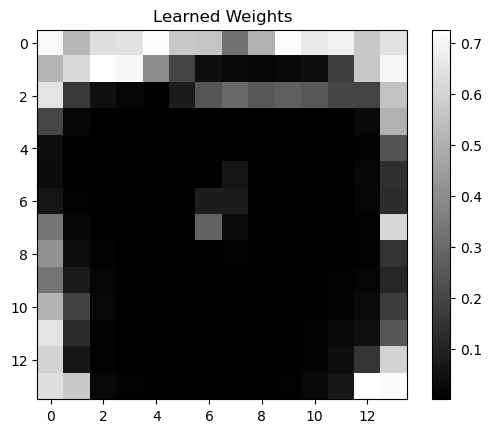

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 7))
test_filter = np.where((y_test == 1) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 1, 1, 0)
y_test_zero = np.where(y_test == 1, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights17 = positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


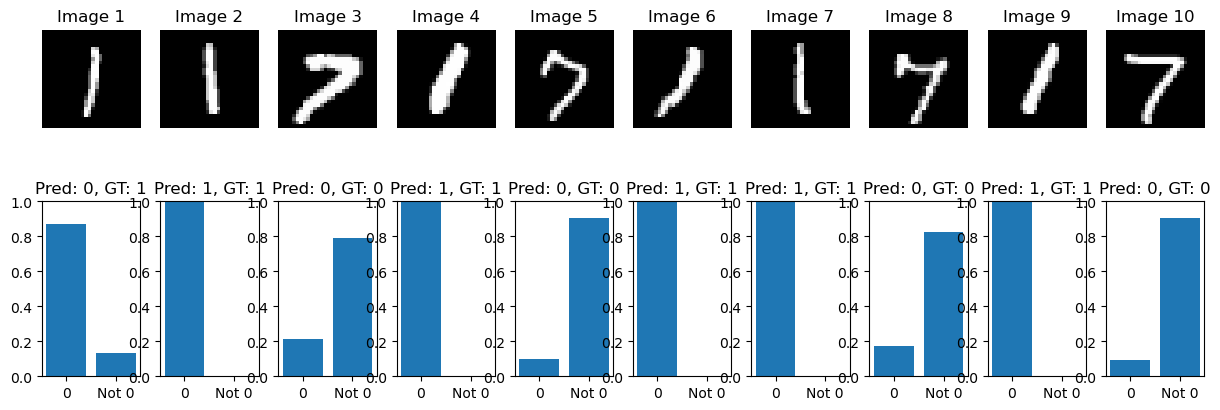

In [30]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 7))
test_filter = np.where((y_test == 1) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 1, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)
predictions = np.dot(x_samples_flat, np_weights17)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

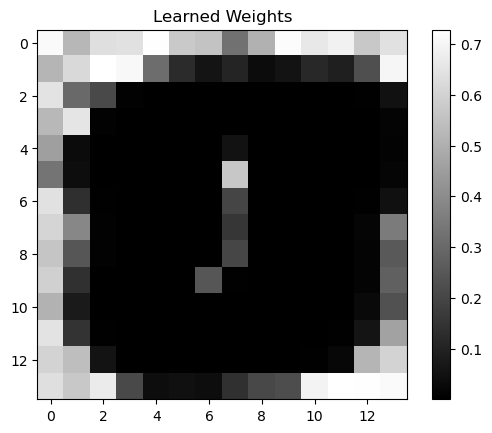

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 8))
test_filter = np.where((y_test == 1) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 1, 1, 0)
y_test_zero = np.where(y_test == 1, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights18 = positive_weights

Classification accuracy on 10 random samples using weight map: 80.00%


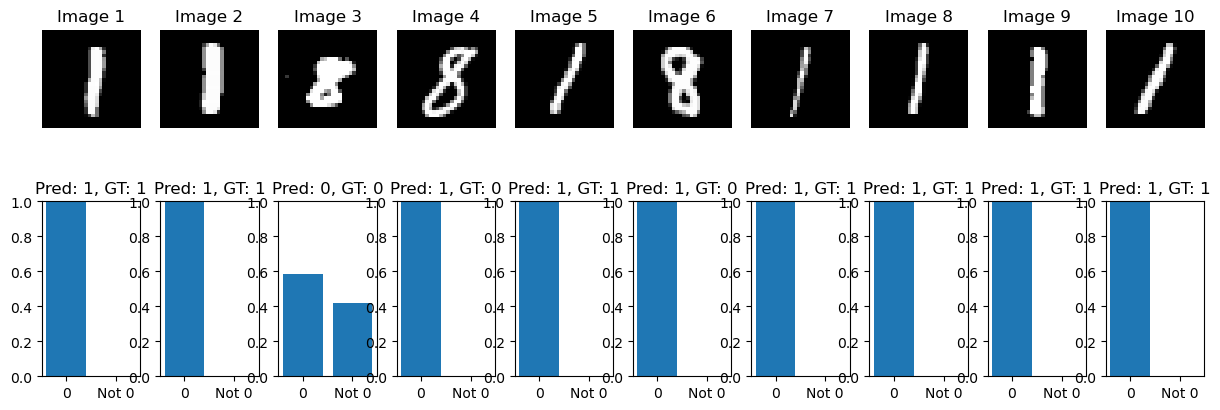

In [32]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 8))
test_filter = np.where((y_test == 1) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 1, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights17)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

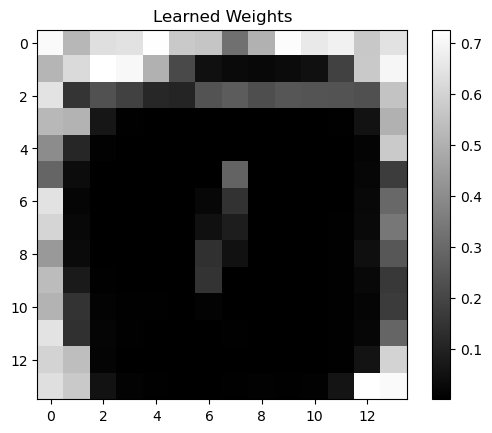

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 9))
test_filter = np.where((y_test == 1) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 1, 1, 0)
y_test_zero = np.where(y_test == 1, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights19 = positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


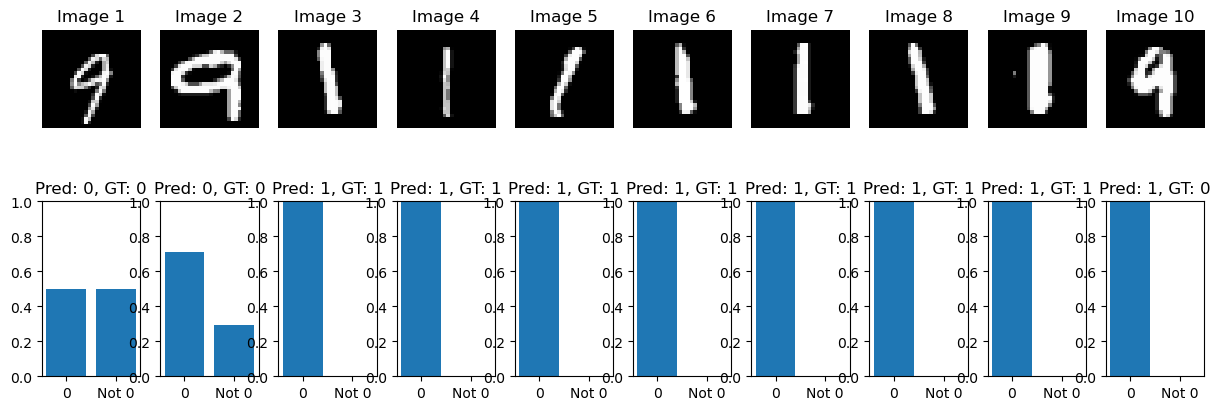

In [34]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 1) | (y_train == 9))
test_filter = np.where((y_test == 1) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 1, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights19)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

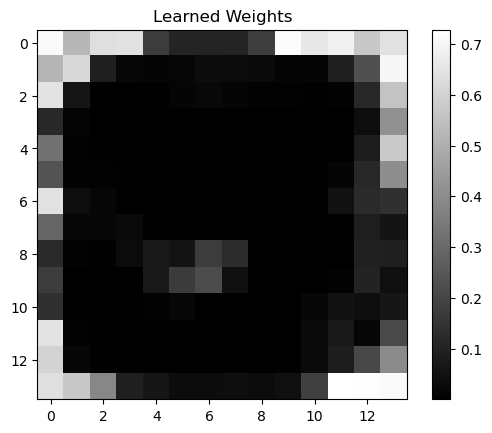

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 3))
test_filter = np.where((y_test == 2) | (y_test == 3))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 2, 1, 0)
y_test_zero = np.where(y_test == 2, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights23 = positive_weights

Classification accuracy on 10 random samples using weight map: 80.00%


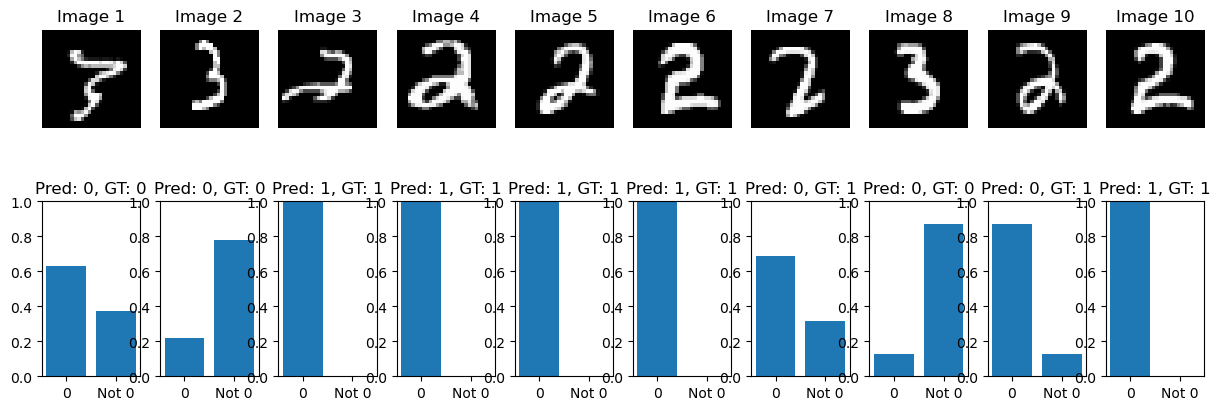

In [36]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 3))
test_filter = np.where((y_test == 2) | (y_test == 3))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 2, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights23)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

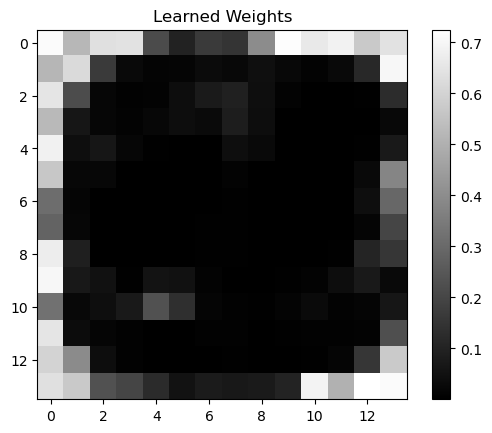

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 4))
test_filter = np.where((y_test == 2) | (y_test == 4))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 2, 1, 0)
y_test_zero = np.where(y_test == 2, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights24 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


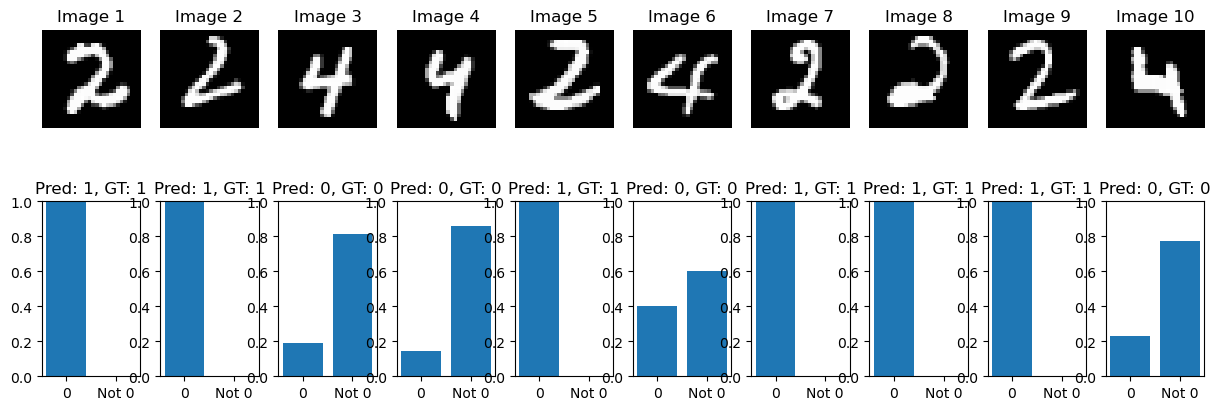

In [38]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 4))
test_filter = np.where((y_test == 2) | (y_test == 4))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 2, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights24)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

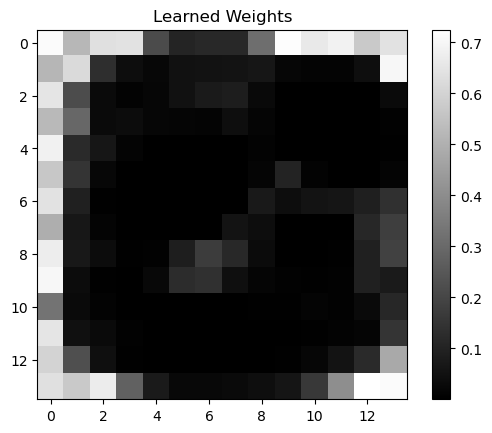

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 5))
test_filter = np.where((y_test == 2) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 2, 1, 0)
y_test_zero = np.where(y_test == 2, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights25 = positive_weights

Classification accuracy on 10 random samples using weight map: 80.00%


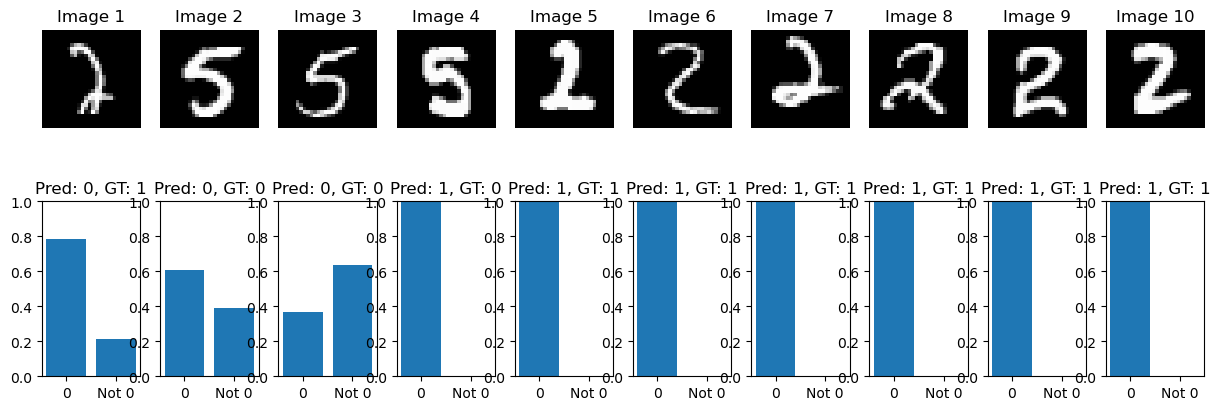

In [40]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 5))
test_filter = np.where((y_test == 2) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 2, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights25)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

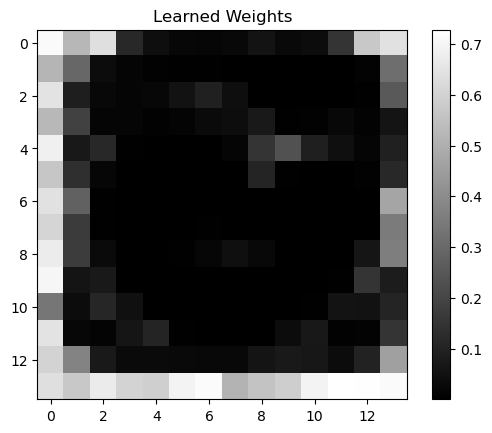

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 6))
test_filter = np.where((y_test == 2) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 2, 1, 0)
y_test_zero = np.where(y_test == 2, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights26 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


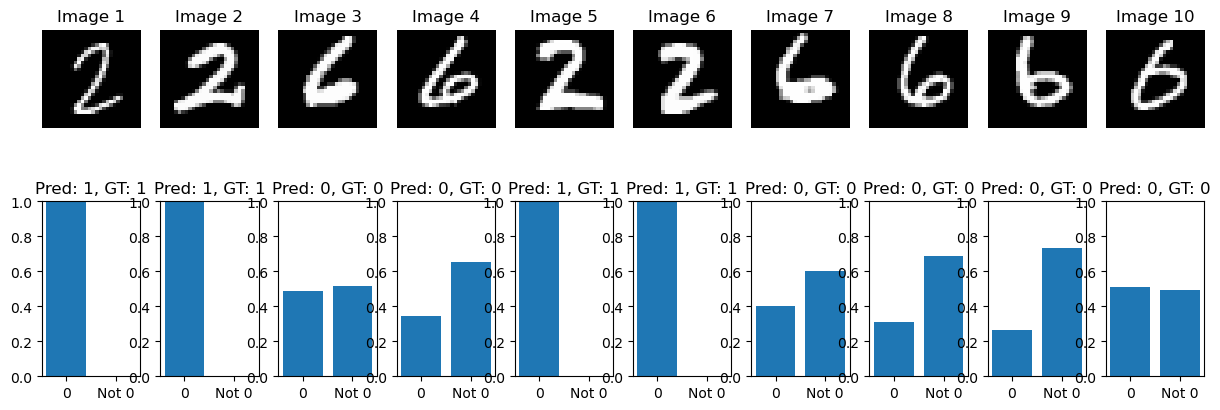

In [42]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 6))
test_filter = np.where((y_test == 2) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 2, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights26)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

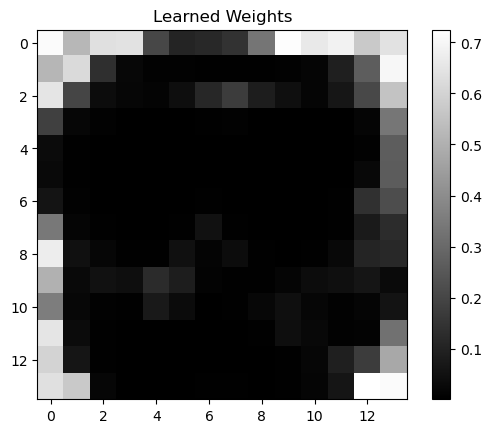

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 7))
test_filter = np.where((y_test == 2) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 2, 1, 0)
y_test_zero = np.where(y_test == 2, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights27 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


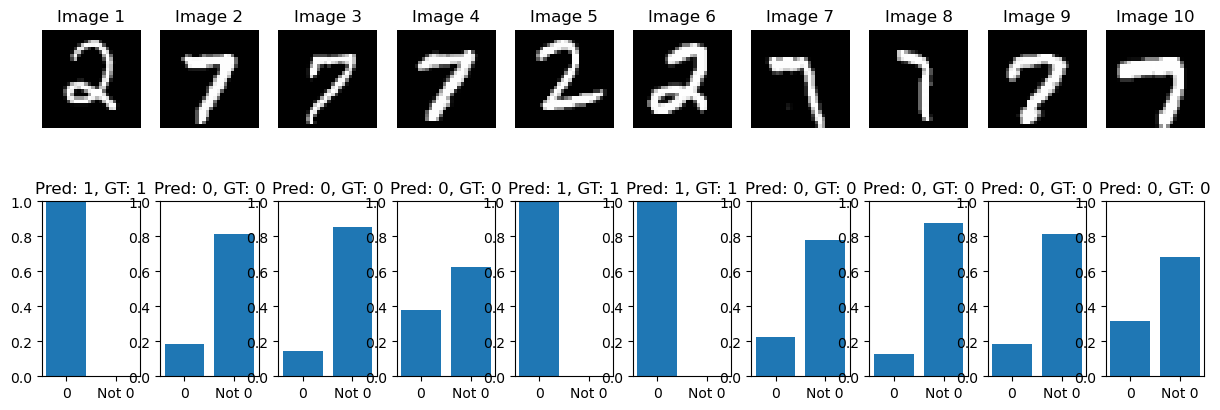

In [44]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 7))
test_filter = np.where((y_test == 2) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 2, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights27)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

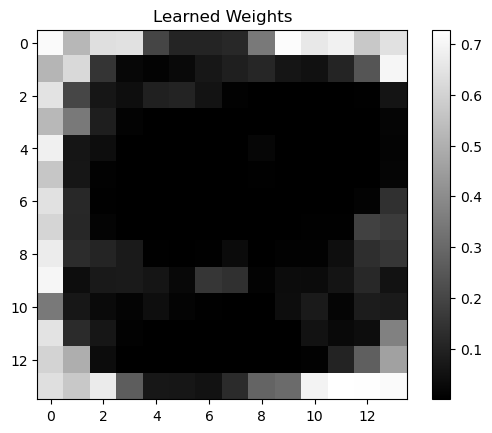

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 8))
test_filter = np.where((y_test == 2) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 2, 1, 0)
y_test_zero = np.where(y_test == 2, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights28 = positive_weights

Classification accuracy on 10 random samples using weight map: 70.00%


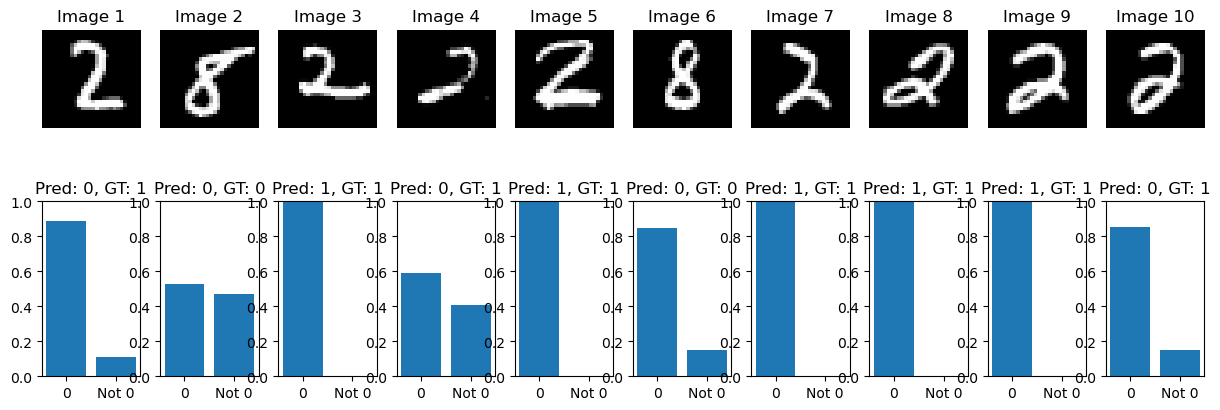

In [46]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train ==8))
test_filter = np.where((y_test == 2) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 2, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights28)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

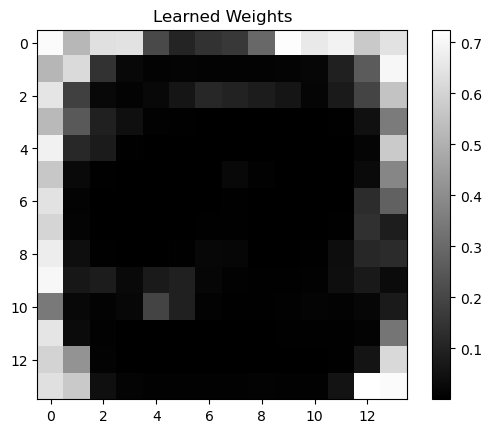

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 9))
test_filter = np.where((y_test == 2) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 2, 1, 0)
y_test_zero = np.where(y_test == 2, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights29 = positive_weights

Classification accuracy on 10 random samples using weight map: 80.00%


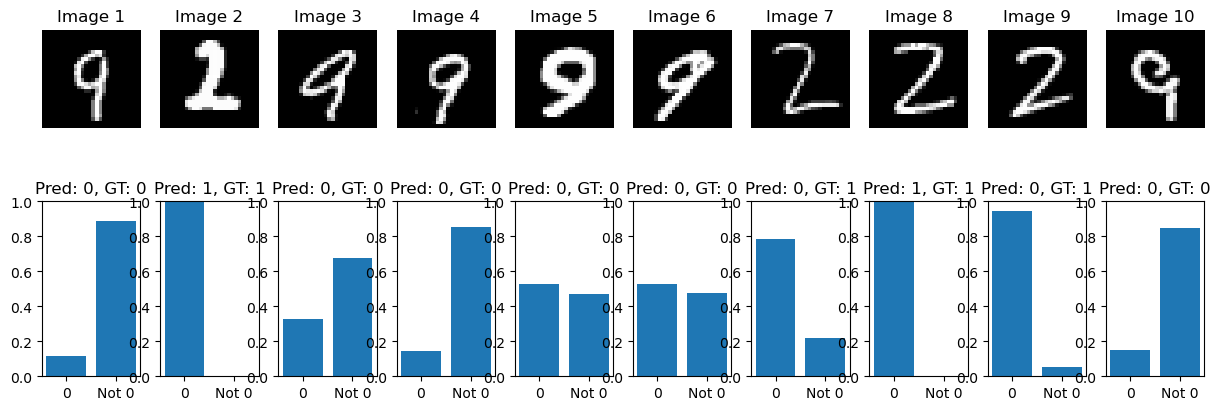

In [48]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 2) | (y_train == 9))
test_filter = np.where((y_test == 2) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 2, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights29)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

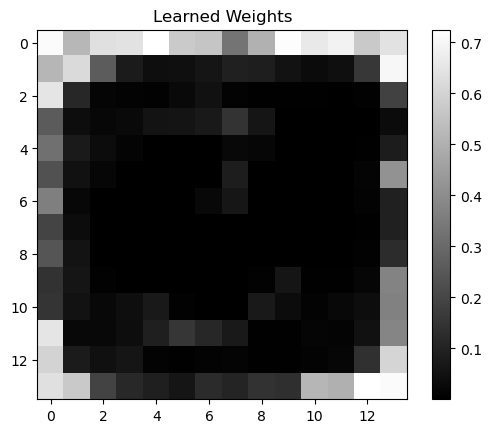

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train == 4))
test_filter = np.where((y_test == 3) | (y_test == 4))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 3, 1, 0)
y_test_zero = np.where(y_test == 3, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights34 = positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


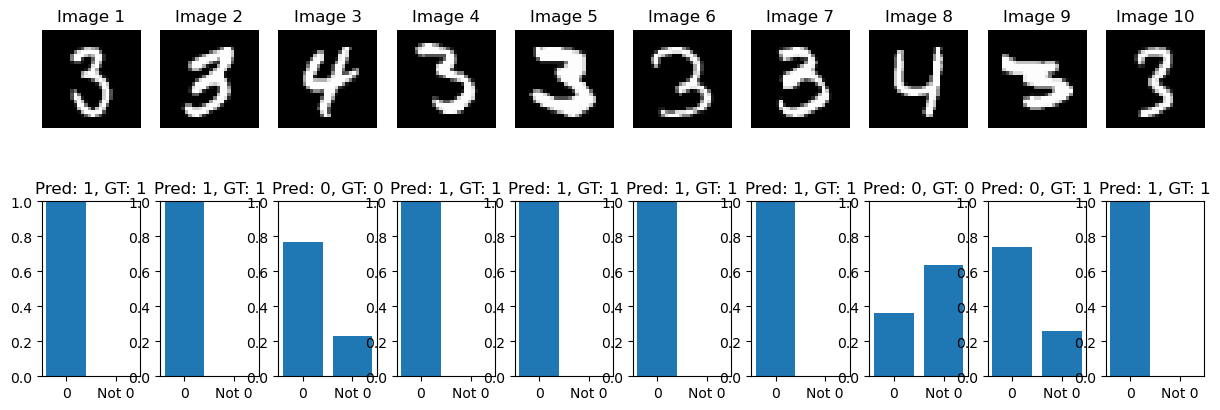

In [50]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train == 4))
test_filter = np.where((y_test == 3) | (y_test == 4))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 3, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights34)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

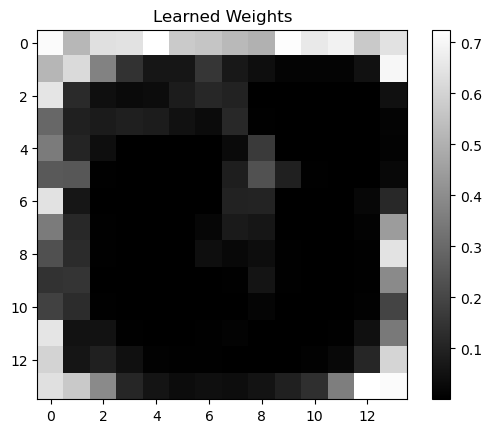

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train == 5))
test_filter = np.where((y_test == 3) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 3, 1, 0)
y_test_zero = np.where(y_test == 3, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights35 = positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


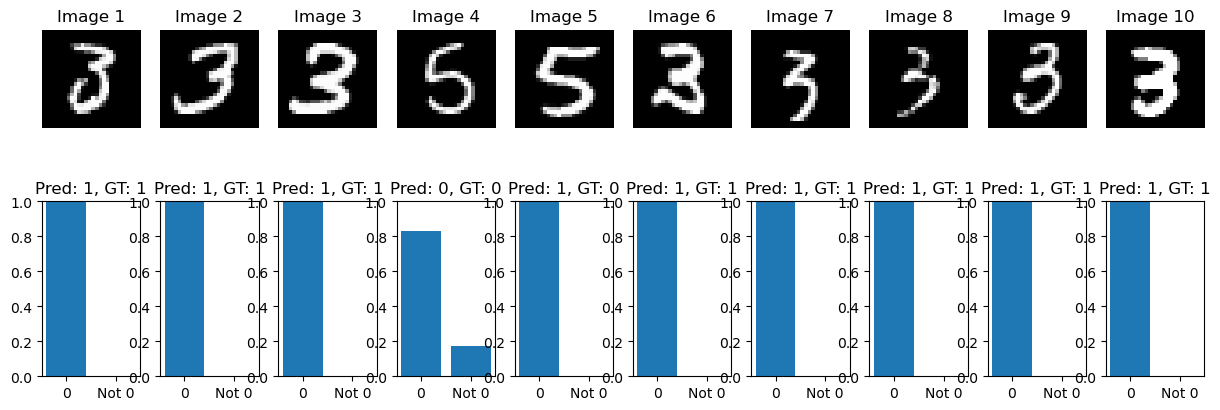

In [52]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train == 5))
test_filter = np.where((y_test == 3) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 3, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights35)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

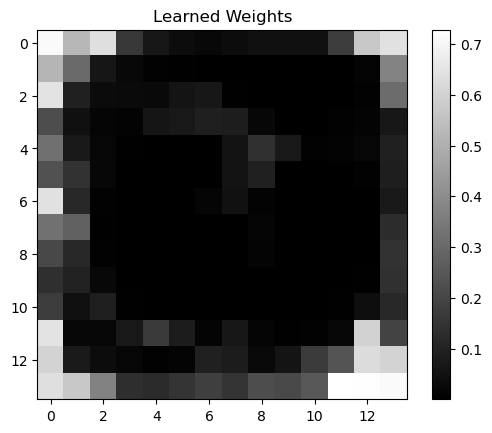

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train == 6))
test_filter = np.where((y_test == 3) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 3, 1, 0)
y_test_zero = np.where(y_test == 3, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights36 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


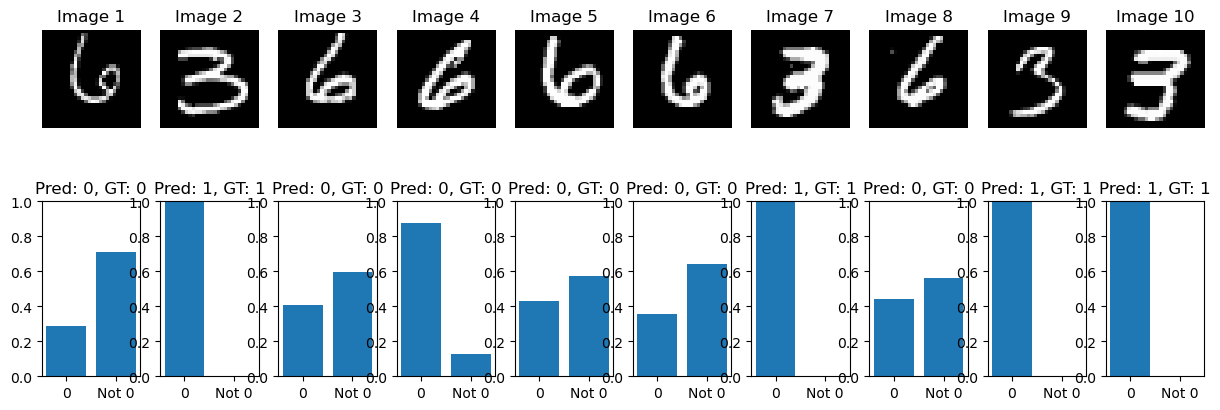

In [54]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train == 6))
test_filter = np.where((y_test == 3) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 3, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights36)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

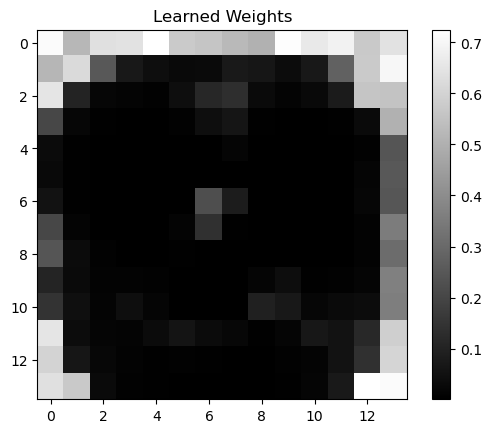

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train == 7))
test_filter = np.where((y_test == 3) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 3, 1, 0)
y_test_zero = np.where(y_test == 3, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights37 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


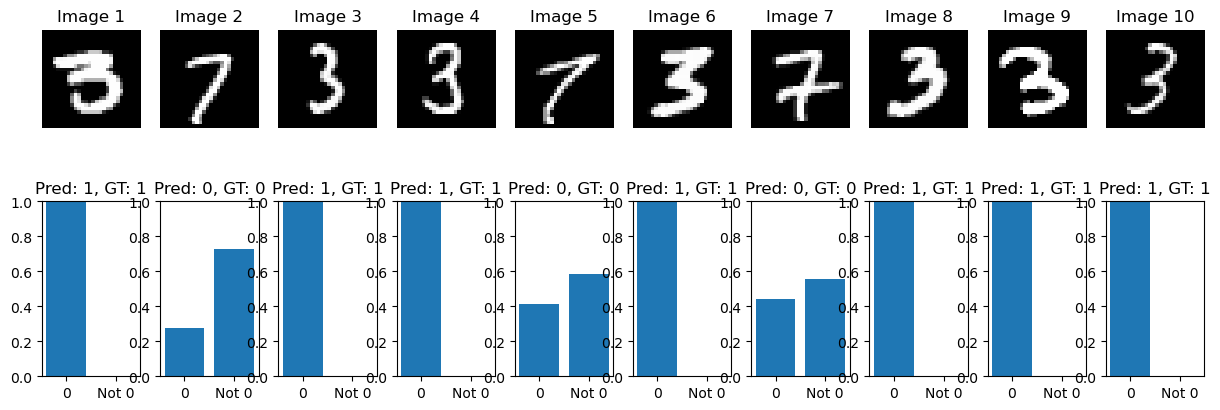

In [56]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train == 7))
test_filter = np.where((y_test == 3) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 3, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights37)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

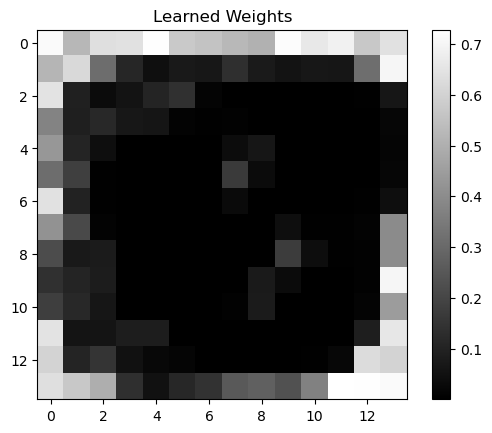

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train == 8))
test_filter = np.where((y_test == 3) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 3, 1, 0)
y_test_zero = np.where(y_test == 3, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights38 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


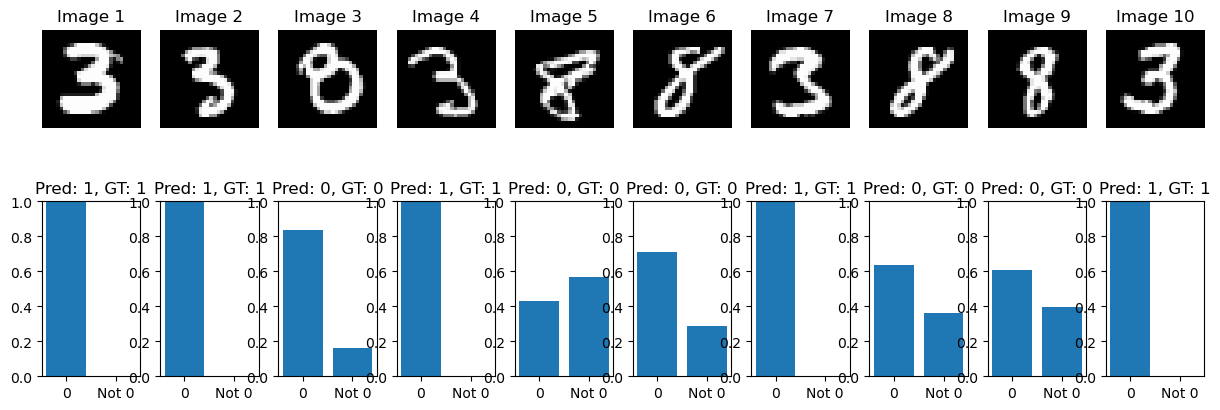

In [58]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train ==8))
test_filter = np.where((y_test == 3) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 3, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights38)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

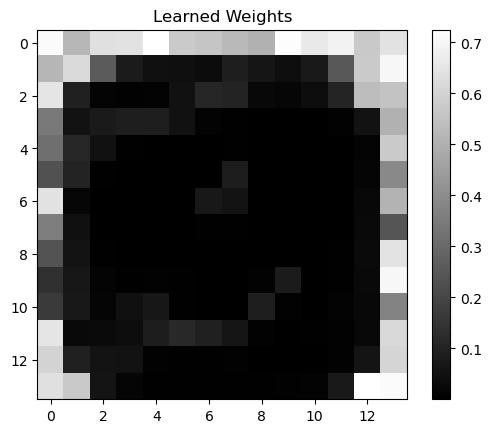

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train == 9))
test_filter = np.where((y_test == 3) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 3, 1, 0)
y_test_zero = np.where(y_test == 3, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights39 = positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


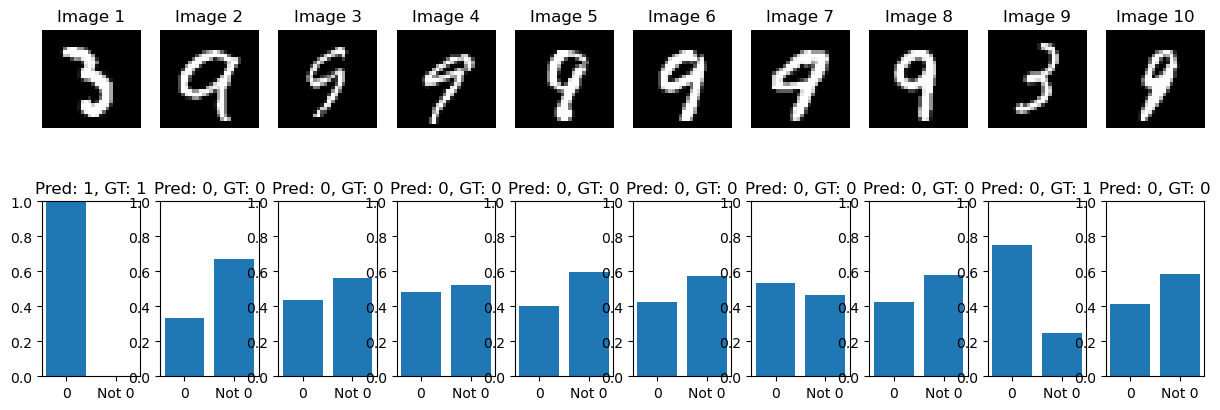

In [60]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 3) | (y_train ==9))
test_filter = np.where((y_test == 3) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 3, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights39)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

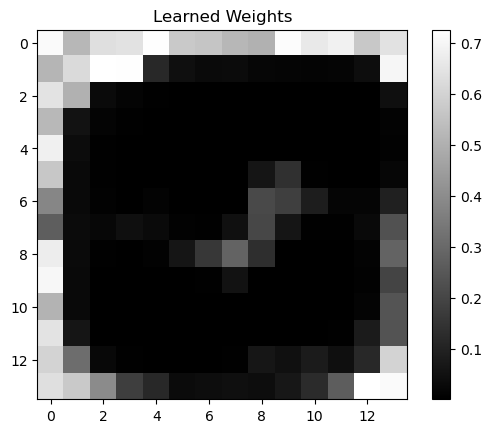

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 4) | (y_train == 5))
test_filter = np.where((y_test == 4) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 4, 1, 0)
y_test_zero = np.where(y_test == 4, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights45= positive_weights

Classification accuracy on 10 random samples using weight map: 80.00%


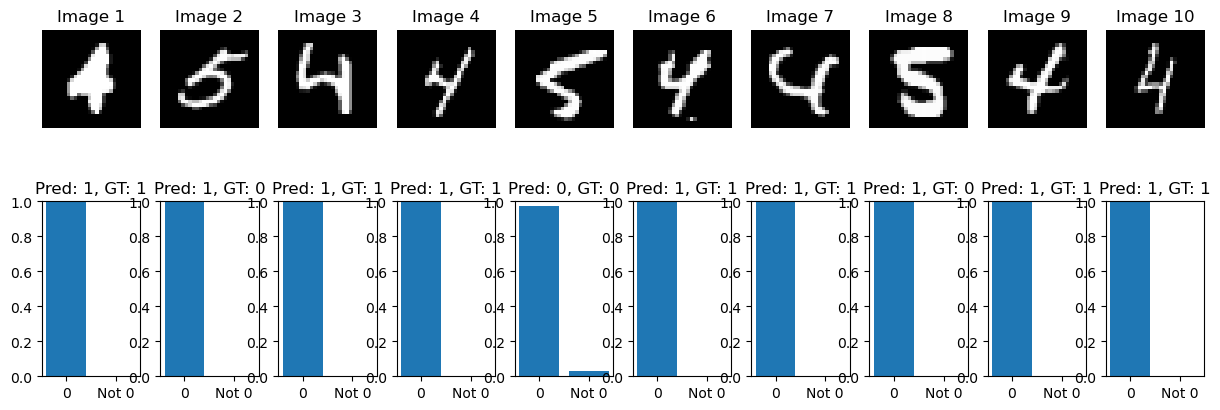

In [62]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 4) | (y_train == 5))
test_filter = np.where((y_test == 4) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 4, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights45)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

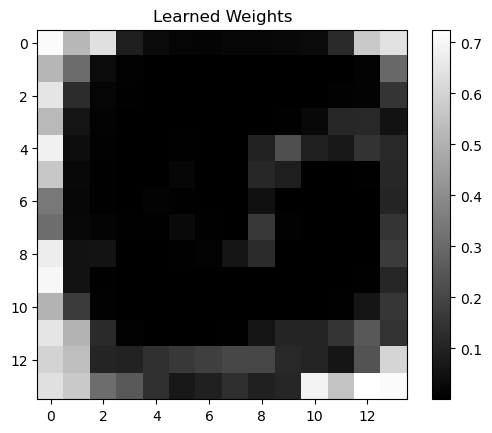

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 4) | (y_train == 6))
test_filter = np.where((y_test == 4) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 4, 1, 0)
y_test_zero = np.where(y_test == 4, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights46= positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


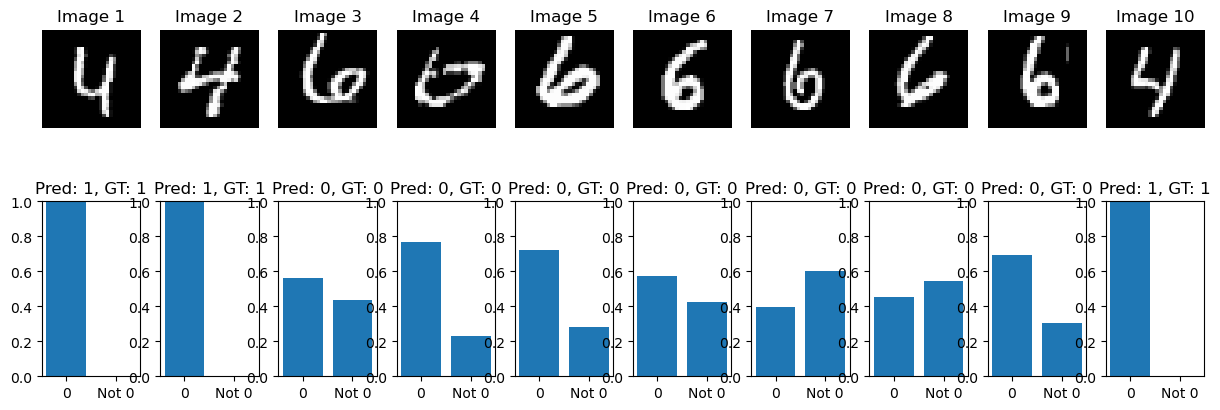

In [64]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 4) | (y_train == 6))
test_filter = np.where((y_test == 4) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 4, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights46)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

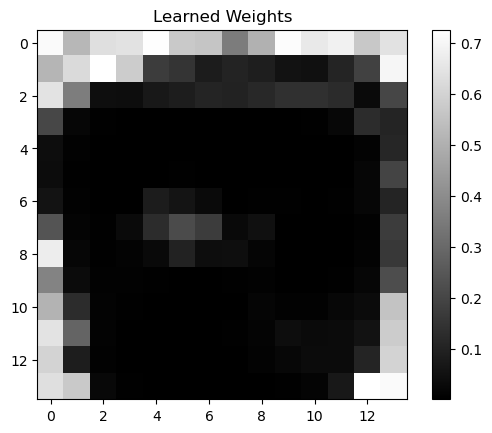

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 4) | (y_train == 7))
test_filter = np.where((y_test == 4) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 4, 1, 0)
y_test_zero = np.where(y_test == 4, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights47= positive_weights

Classification accuracy on 10 random samples using weight map: 80.00%


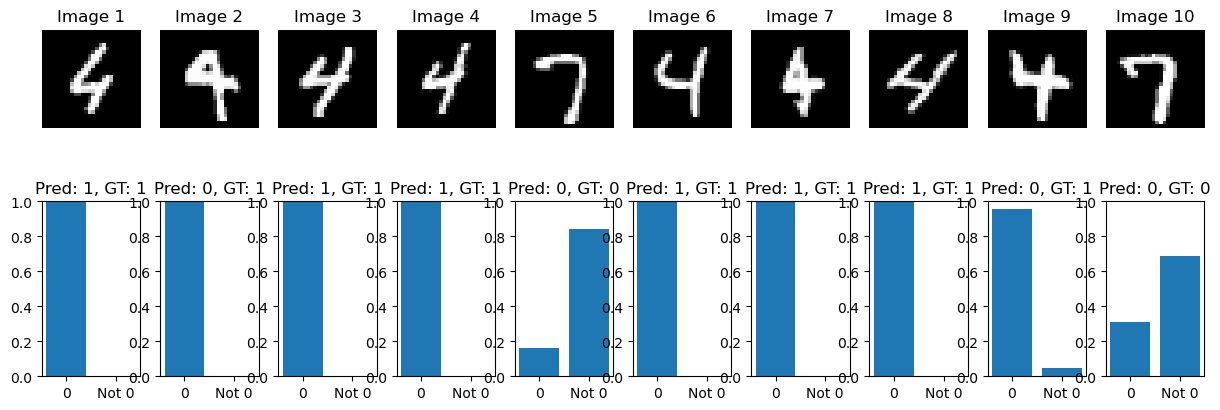

In [66]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 4) | (y_train == 7))
test_filter = np.where((y_test == 4) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 4, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)
predictions = np.dot(x_samples_flat, np_weights47)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

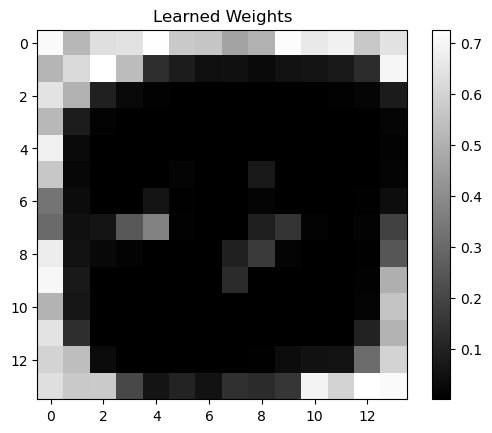

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 4) | (y_train == 8))
test_filter = np.where((y_test == 4) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 4, 1, 0)
y_test_zero = np.where(y_test == 4, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights48= positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


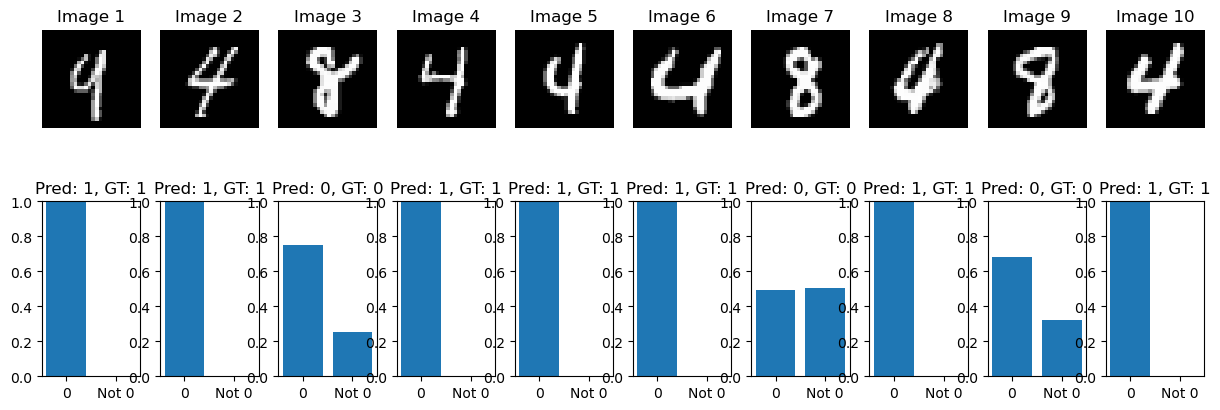

In [68]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 4) | (y_train == 8))
test_filter = np.where((y_test == 4) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 4, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights48)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

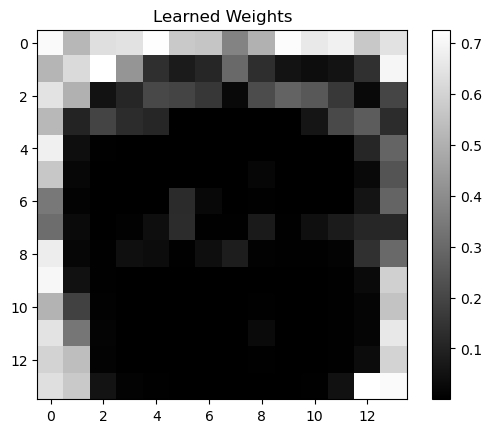

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 4) | (y_train == 9))
test_filter = np.where((y_test == 4) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]


y_train_zero = np.where(y_train == 4, 1, 0)
y_test_zero = np.where(y_test == 4, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights49= positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


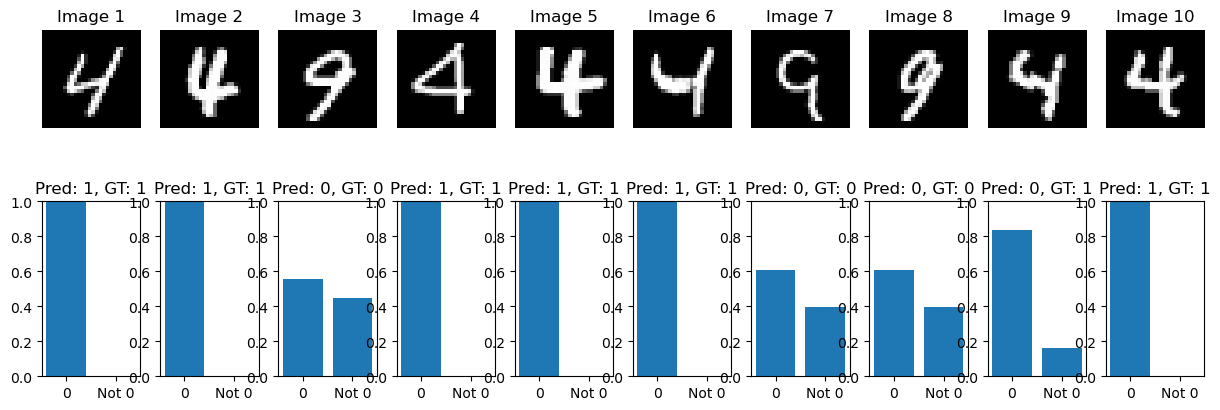

In [70]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 4) | (y_train == 9))
test_filter = np.where((y_test == 4) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 4, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights49)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

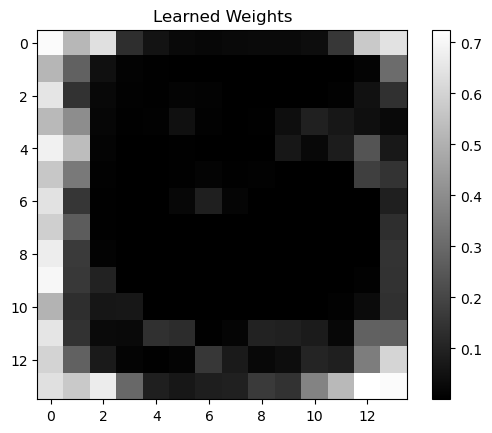

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 5) | (y_train == 6))
test_filter = np.where((y_test == 5) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

y_train_zero = np.where(y_train == 5, 1, 0)
y_test_zero = np.where(y_test == 5, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights56= positive_weights

Classification accuracy on 10 random samples using weight map: 60.00%


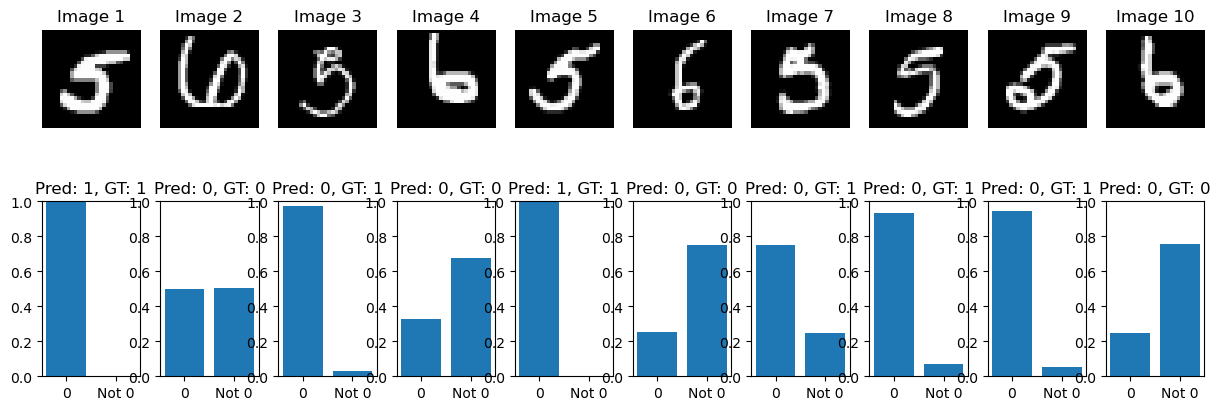

In [72]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 5) | (y_train == 6))
test_filter = np.where((y_test == 5) | (y_test == 6))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 5, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights56)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

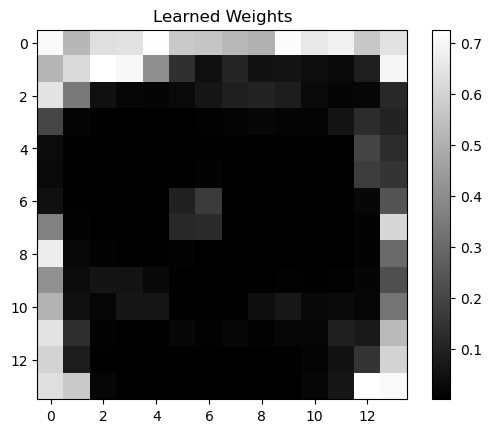

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes
class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 5) | (y_train == 7))
test_filter = np.where((y_test == 5) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

y_train_zero = np.where(y_train == 5, 1, 0)
y_test_zero = np.where(y_test == 5, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights57= positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


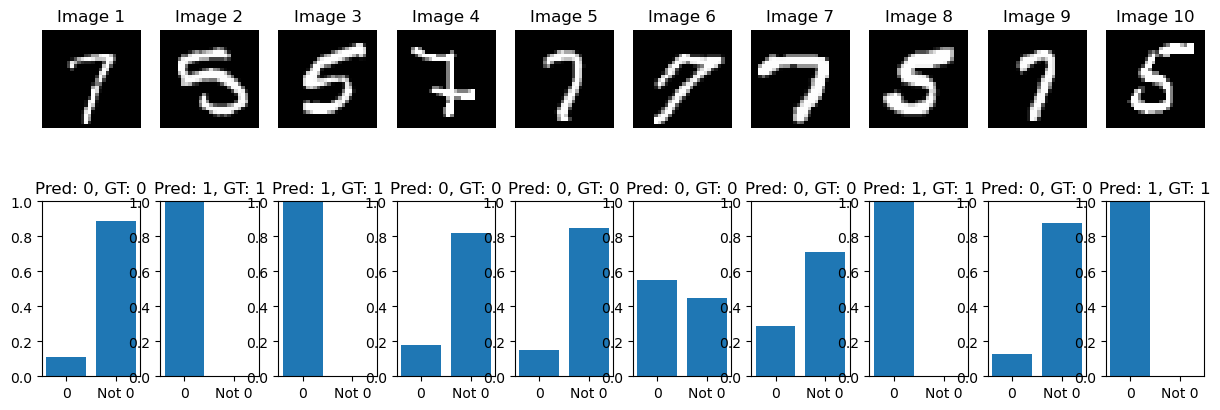

In [74]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 5) | (y_train == 7))
test_filter = np.where((y_test == 5) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 5, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights57)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

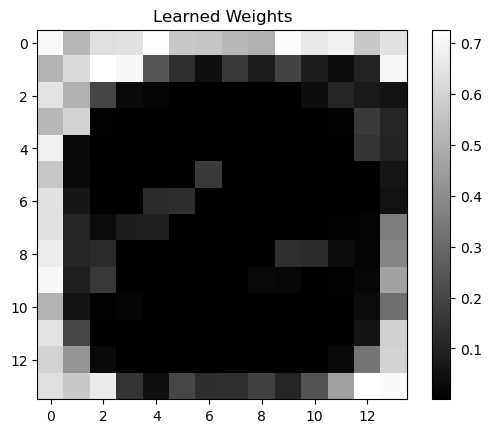

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 5) | (y_train == 8))
test_filter = np.where((y_test == 5) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

y_train_zero = np.where(y_train == 5, 1, 0)
y_test_zero = np.where(y_test == 5, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights58= positive_weights

Classification accuracy on 10 random samples using weight map: 70.00%


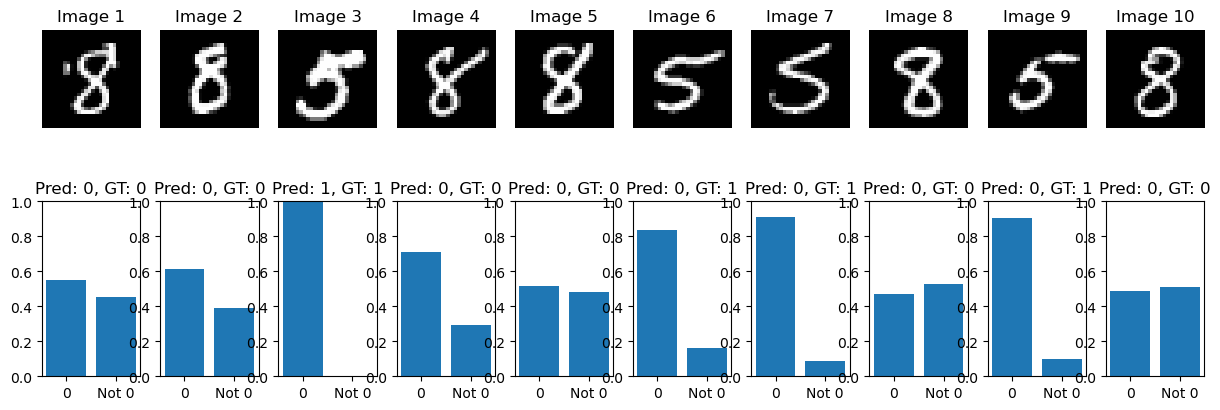

In [76]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 5) | (y_train == 8))
test_filter = np.where((y_test == 5) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 5, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights58)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

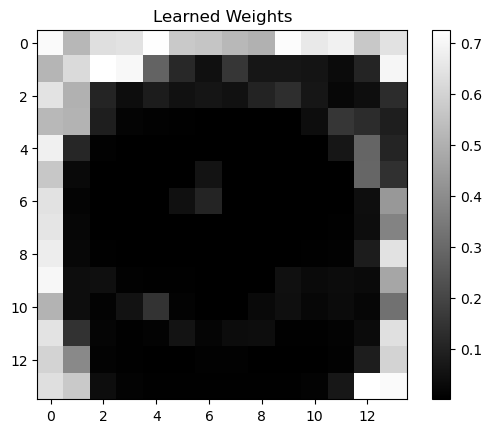

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 5) | (y_train == 9))
test_filter = np.where((y_test == 5) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

y_train_zero = np.where(y_train == 5, 1, 0)
y_test_zero = np.where(y_test == 5, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights59 = positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


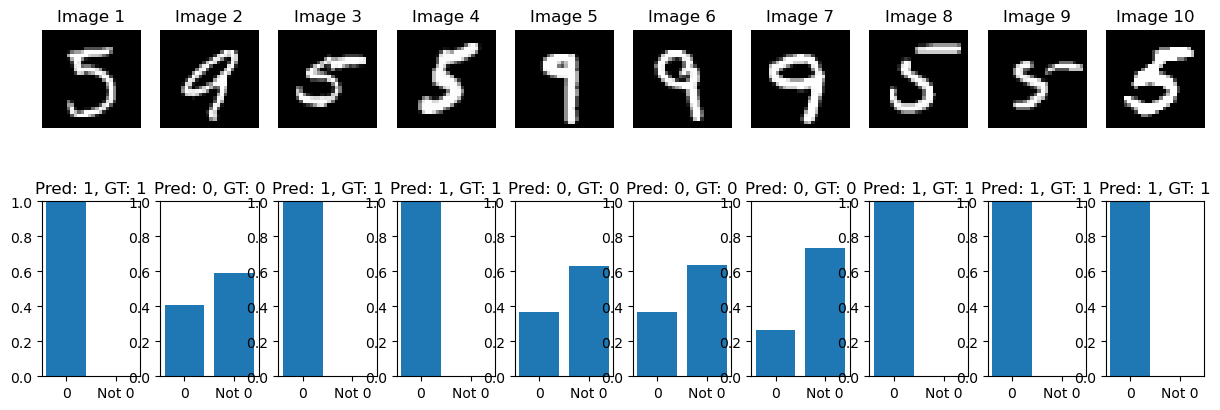

In [78]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 5) | (y_train == 9))
test_filter = np.where((y_test == 5) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 5, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights59)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

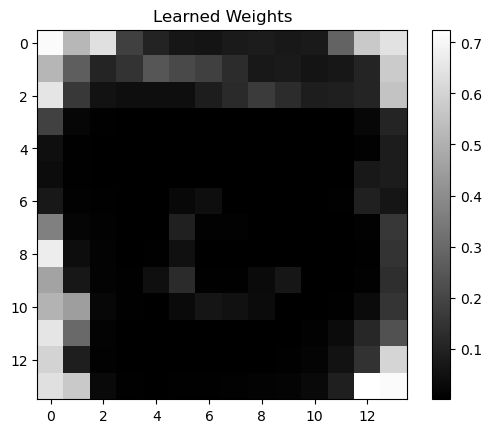

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 6) | (y_train == 7))
test_filter = np.where((y_test == 6) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

y_train_zero = np.where(y_train == 6, 1, 0)
y_test_zero = np.where(y_test == 6, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights67= positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


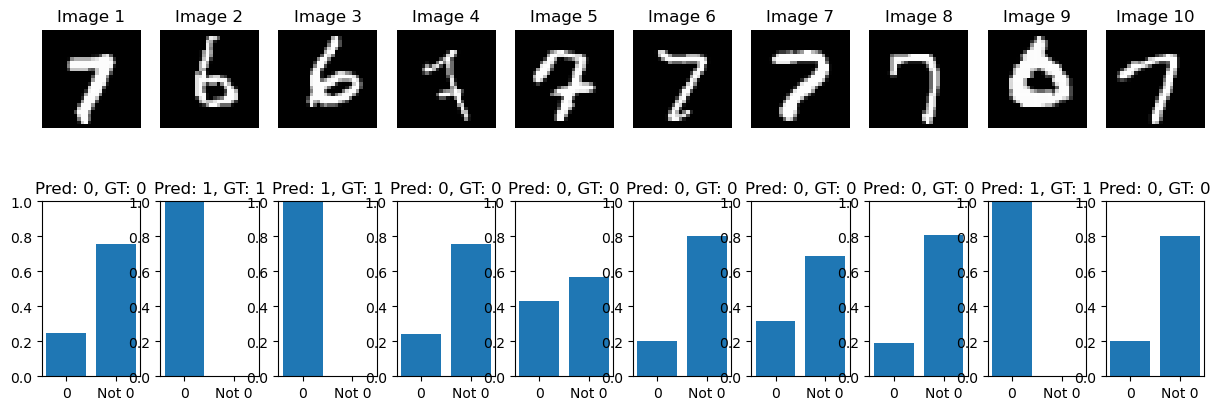

In [80]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 6) | (y_train == 7))
test_filter = np.where((y_test == 6) | (y_test == 7))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 6, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights67)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

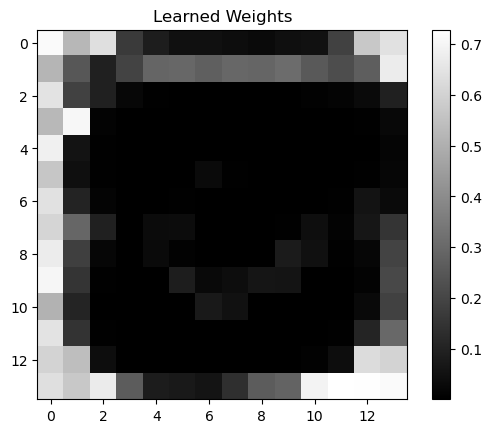

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 6) | (y_train == 8))
test_filter = np.where((y_test == 6) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

y_train_zero = np.where(y_train == 6, 1, 0)
y_test_zero = np.where(y_test == 6, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights68= positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


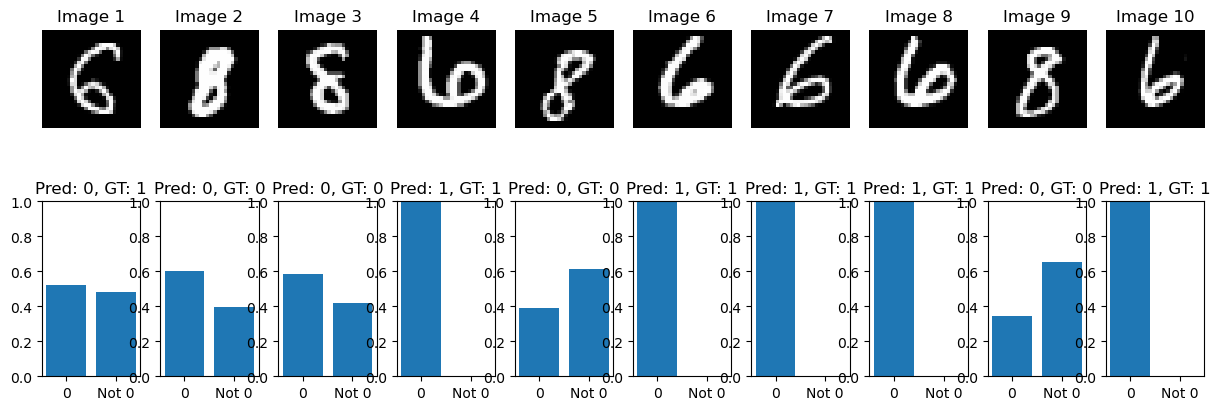

In [82]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 6) | (y_train == 8))
test_filter = np.where((y_test == 6) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 6, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights68)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

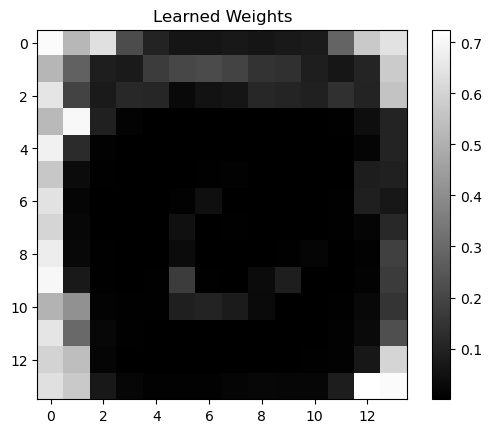

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 6) | (y_train == 9))
test_filter = np.where((y_test == 6) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

y_train_zero = np.where(y_train == 6, 1, 0)
y_test_zero = np.where(y_test == 6, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights69= positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


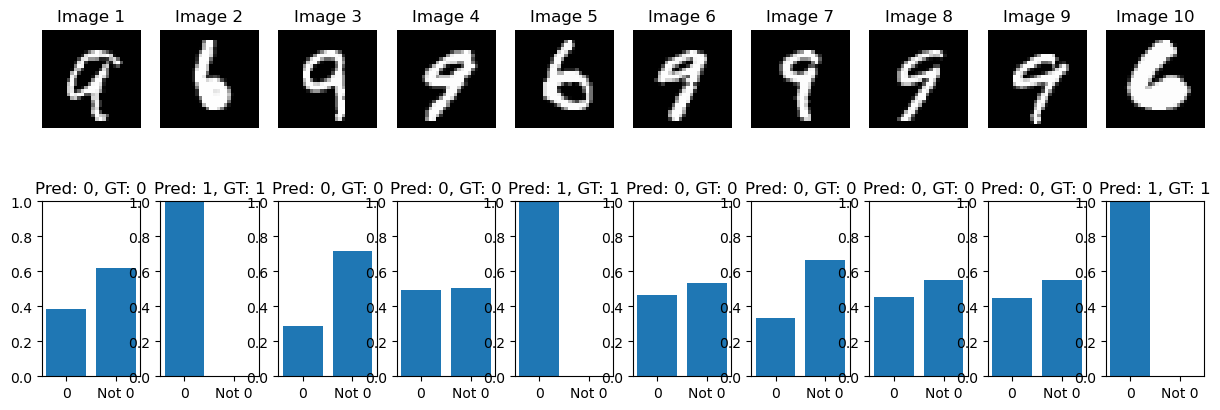

In [84]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 6) | (y_train == 9))
test_filter = np.where((y_test == 6) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 6, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights69)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

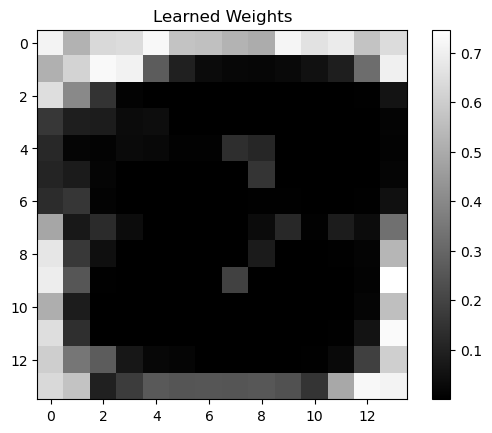

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 7) | (y_train == 8))
test_filter = np.where((y_test == 7) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

y_train_zero = np.where(y_train == 7, 1, 0)
y_test_zero = np.where(y_test == 7, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights78= positive_weights

Classification accuracy on 10 random samples using weight map: 100.00%


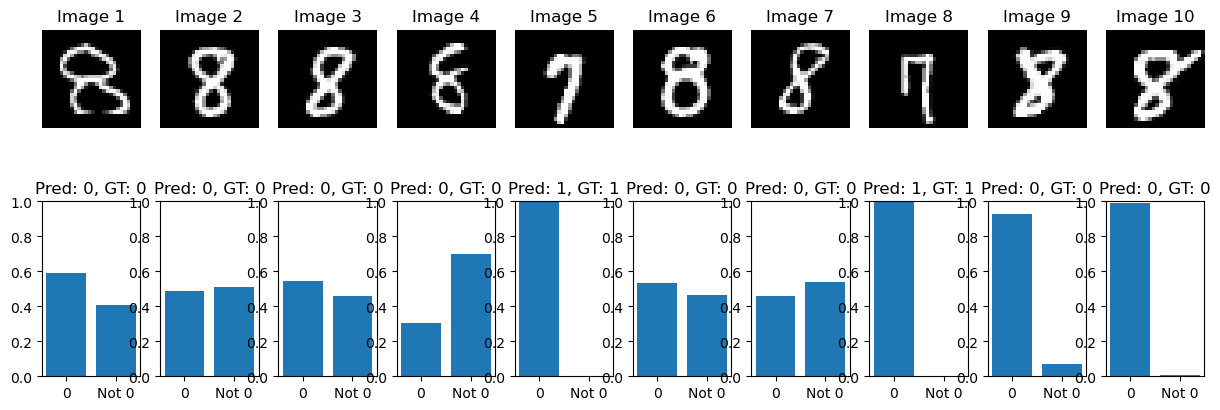

In [86]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 7) | (y_train == 8))
test_filter = np.where((y_test == 7) | (y_test == 8))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 7, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights78)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

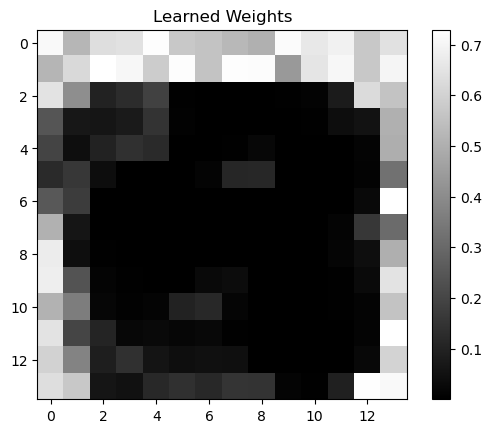

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes


class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 7) | (y_train == 9))
test_filter = np.where((y_test == 7) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

y_train_zero = np.where(y_train == 7, 1, 0)
y_test_zero = np.where(y_test == 7, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights79= positive_weights

Classification accuracy on 10 random samples using weight map: 80.00%


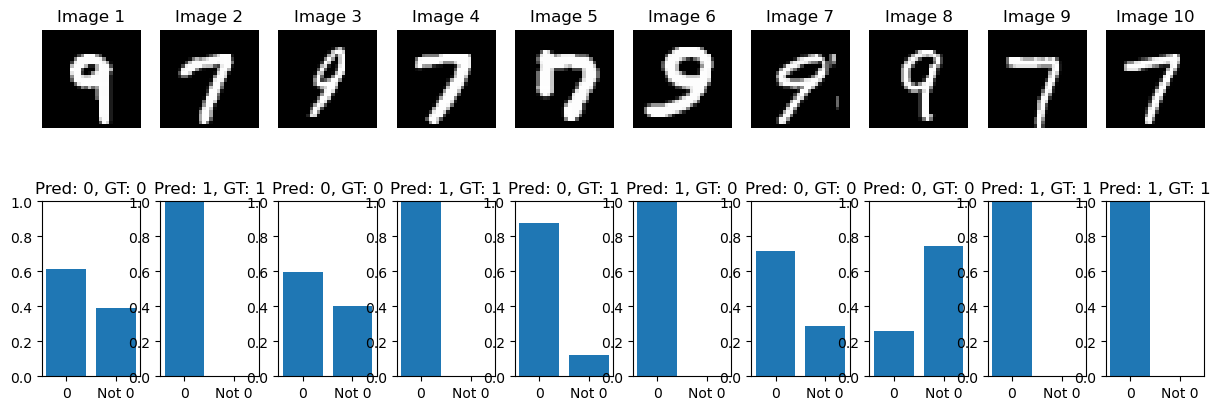

In [88]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 7) | (y_train == 9))
test_filter = np.where((y_test == 7) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 7, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights79)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



Epoch 1/590
Epoch 2/590
Epoch 3/590
Epoch 4/590
Epoch 5/590
Epoch 6/590
Epoch 7/590
Epoch 8/590
Epoch 9/590
Epoch 10/590
Epoch 11/590
Epoch 12/590
Epoch 13/590
Epoch 14/590
Epoch 15/590
Epoch 16/590
Epoch 17/590
Epoch 18/590
Epoch 19/590
Epoch 20/590
Epoch 21/590
Epoch 22/590
Epoch 23/590
Epoch 24/590
Epoch 25/590
Epoch 26/590
Epoch 27/590
Epoch 28/590
Epoch 29/590
Epoch 30/590
Epoch 31/590
Epoch 32/590
Epoch 33/590
Epoch 34/590
Epoch 35/590
Epoch 36/590
Epoch 37/590
Epoch 38/590
Epoch 39/590
Epoch 40/590
Epoch 41/590
Epoch 42/590
Epoch 43/590
Epoch 44/590
Epoch 45/590
Epoch 46/590
Epoch 47/590
Epoch 48/590
Epoch 49/590
Epoch 50/590
Epoch 51/590
Epoch 52/590
Epoch 53/590
Epoch 54/590
Epoch 55/590
Epoch 56/590
Epoch 57/590
Epoch 58/590
Epoch 59/590
Epoch 60/590
Epoch 61/590
Epoch 62/590
Epoch 63/590
Epoch 64/590
Epoch 65/590
Epoch 66/590
Epoch 67/590
Epoch 68/590
Epoch 69/590
Epoch 70/590
Epoch 71/590
Epoch 72/590
Epoch 73/590
Epoch 74/590
Epoch 75/590
Epoch 76/590
Epoch 77/590
Epoch 78

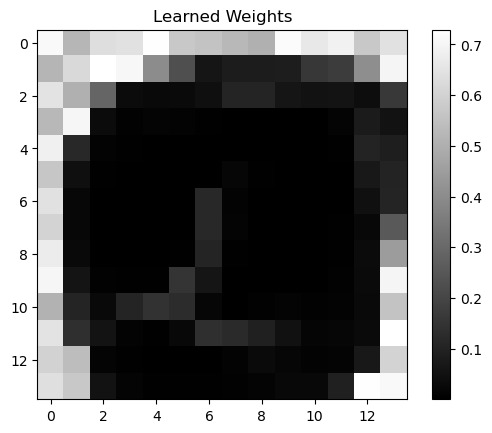

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 8) | (y_train == 9))
test_filter = np.where((y_test == 8) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

y_train_zero = np.where(y_train == 8, 1, 0)
y_test_zero = np.where(y_test == 8, 1, 0)

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)


x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

np.random.seed(0)
w = np.random.randn(input_shape[0] * input_shape[1], 1)
b = np.random.randn()
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(x_train_spikes), batch_size):
        batch_inputs = x_train_spikes[i:i + batch_size]
        batch_labels = y_train_zero[i:i + batch_size]

        batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
        outputs = sigmoid_layer.forward(batch_inputs_flat)
        error = outputs - batch_labels[:, np.newaxis]

        sigmoid_layer.update_weights(batch_inputs_flat, error)

correct_predictions = 0
for inputs, label in zip(x_test_spikes, y_test_zero):
    inputs_flat = inputs.reshape((1, -1))
    output = sigmoid_layer.forward(inputs_flat)
    prediction = int(output > 0.5)
    correct_predictions += int(prediction == label)

accuracy = correct_predictions / len(x_test_spikes)
print("Classification accuracy on test set: {:.2f}%".format(100 * accuracy))

positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
plt.imshow(positive_weights.reshape(14, 14), cmap='gray')
plt.colorbar()
plt.title("Learned Weights")
plt.show()
np_weights89= positive_weights

Classification accuracy on 10 random samples using weight map: 90.00%


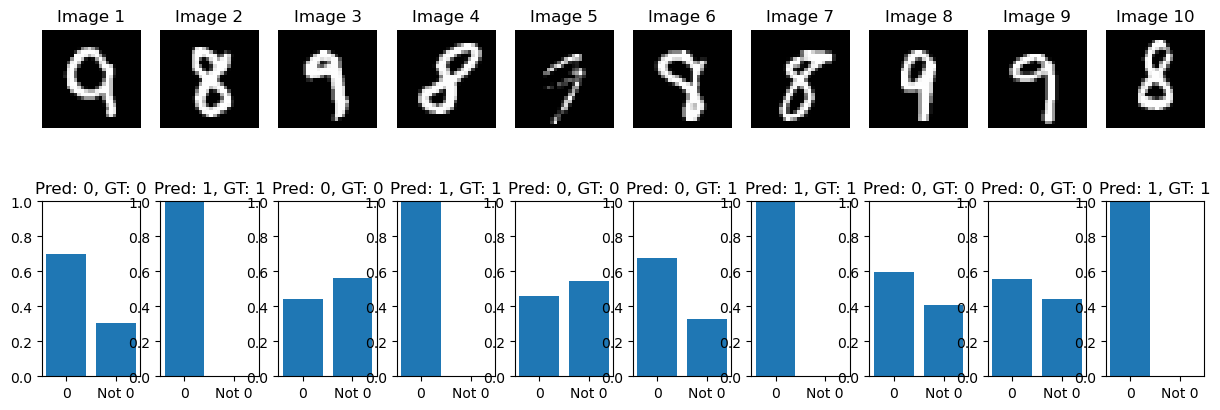

In [90]:
num_samples = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 8) | (y_train == 9))
test_filter = np.where((y_test == 8) | (y_test == 9))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_samples = x_test[sample_indices]
y_samples = y_test[sample_indices]

y_samples_zero = np.where(y_samples == 8, 1, 0)

x_samples_resized = np.array([cv2.resize(img, (14, 14)) for img in x_samples])
x_samples_spikes = np.zeros((x_samples_resized.shape[0], 14, 14))
for i in range(x_samples_resized.shape[0]):
    x_samples_spikes[i] = temporal_encoding(x_samples_resized[i], dt, threshold)
x_samples_flat = x_samples_spikes.reshape(x_samples_spikes.shape[0], -1)

predictions = np.dot(x_samples_flat, np_weights89)

predictions_normalized = predictions / (1 + predictions)

predicted_labels = np.where(predictions_normalized >= 0.5, 1, 0).reshape(-1)

correct_predictions = np.sum(predicted_labels == y_samples_zero)
accuracy = correct_predictions / num_samples * 100

print("Classification accuracy on 10 random samples using weight map: {:.2f}%".format(accuracy))

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(x_samples[i], cmap="gray")
    plt.axis("off")
    plt.title("Image {}".format(i + 1))

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.bar(["0", "Not 0"], [predictions[i, 0], 1 - predictions[i, 0]])
    plt.ylim([0, 1])
    plt.title("Pred: {}, GT: {}".format(predicted_labels[i], y_samples_zero[i]))

plt.show()



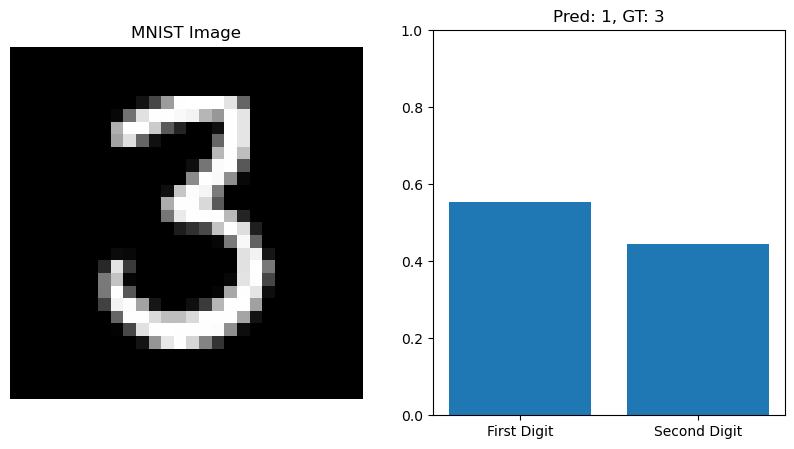

In [91]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_sample = x_test[927]
y_sample = y_test[927]

x_sample_resized = cv2.resize(x_sample, (14, 14))

x_sample_spikes = temporal_encoding(x_sample_resized, dt, threshold)

x_sample_flat = x_sample_spikes.reshape(1, -1)

# 01 -> 02 -> 23 -> 34 -> 35 -> 36 -> 37 -> 38 ->39 ->3 
weight_map = np_weights39
prediction = np.dot(x_sample_flat, weight_map)
prediction_normalized = prediction / (1 + prediction)
predicted_label = 1 if prediction_normalized[0, 0] >= 0.5 else 0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_sample, cmap="gray")
plt.axis("off")
plt.title("MNIST Image")

plt.subplot(1, 2, 2)
plt.bar(["First Digit", "Second Digit"], [prediction_normalized[0, 0], 1 - prediction_normalized[0, 0]])
plt.ylim([0, 1])
plt.title("Pred: {}, GT: {}".format(predicted_label, y_sample))

plt.show()


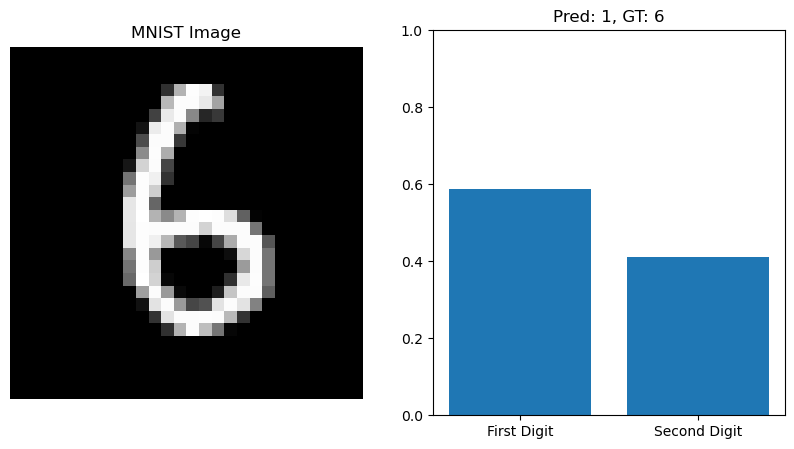

In [92]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_sample = x_test[21]
y_sample = y_test[21]

x_sample_resized = cv2.resize(x_sample, (14, 14))

x_sample_spikes = temporal_encoding(x_sample_resized, dt, threshold)

x_sample_flat = x_sample_spikes.reshape(1, -1)

# 01 -> 02 -> 23 -> 24 -> 25 -> 26 -> 67 -> 68 ->69 -> 6
weight_map = np_weights69
prediction = np.dot(x_sample_flat, weight_map)
prediction_normalized = prediction / (1 + prediction)
predicted_label = 1 if prediction_normalized[0, 0] >= 0.5 else 0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_sample, cmap="gray")
plt.axis("off")
plt.title("MNIST Image")

plt.subplot(1, 2, 2)
plt.bar(["First Digit", "Second Digit"], [prediction_normalized[0, 0], 1 - prediction_normalized[0, 0]])
plt.ylim([0, 1])
plt.title("Pred: {}, GT: {}".format(predicted_label, y_sample))

plt.show()


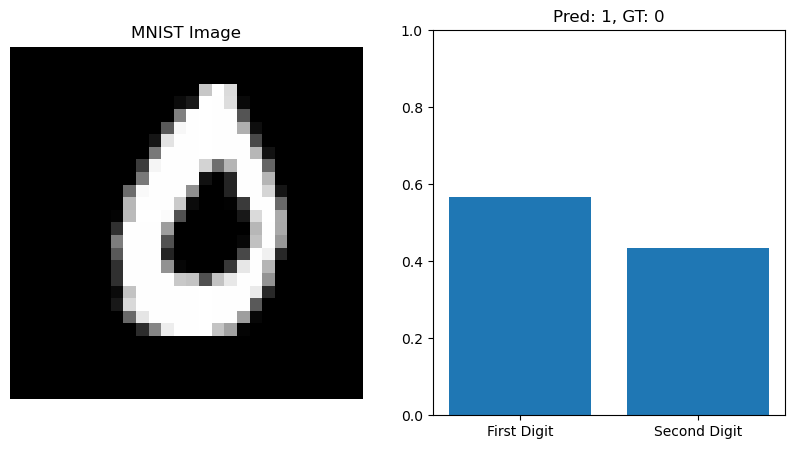

In [93]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_sample = x_test[1121]
y_sample = y_test[1121]

x_sample_resized = cv2.resize(x_sample, (14, 14))

x_sample_spikes = temporal_encoding(x_sample_resized, dt, threshold)

x_sample_flat = x_sample_spikes.reshape(1, -1)

# 01 -> 02 -> 03 -> 04 -> 05 -> 06 -> 07 -> 08 ->09 -> 0
weight_map = np_weights09
prediction = np.dot(x_sample_flat, weight_map)
prediction_normalized = prediction / (1 + prediction)
predicted_label = 1 if prediction_normalized[0, 0] >= 0.5 else 0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_sample, cmap="gray")
plt.axis("off")
plt.title("MNIST Image")

plt.subplot(1, 2, 2)
plt.bar(["First Digit", "Second Digit"], [prediction_normalized[0, 0], 1 - prediction_normalized[0, 0]])
plt.ylim([0, 1])
plt.title("Pred: {}, GT: {}".format(predicted_label, y_sample))

plt.show()


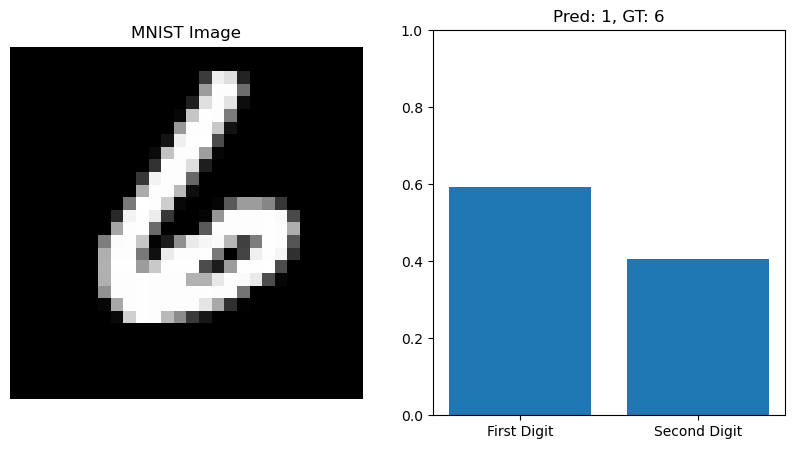

In [94]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_sample = x_test[8888]
y_sample = y_test[8888]

x_sample_resized = cv2.resize(x_sample, (14, 14))

x_sample_spikes = temporal_encoding(x_sample_resized, dt, threshold)

x_sample_flat = x_sample_spikes.reshape(1, -1)

# 01 -> 02 -> 03 -> 04 -> 05 -> 06 -> 67 -> 68 ->69 -> 0
weight_map = np_weights69
prediction = np.dot(x_sample_flat, weight_map)
prediction_normalized = prediction / (1 + prediction)
predicted_label = 1 if prediction_normalized[0, 0] >= 0.5 else 0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_sample, cmap="gray")
plt.axis("off")
plt.title("MNIST Image")

plt.subplot(1, 2, 2)
plt.bar(["First Digit", "Second Digit"], [prediction_normalized[0, 0], 1 - prediction_normalized[0, 0]])
plt.ylim([0, 1])
plt.title("Pred: {}, GT: {}".format(predicted_label, y_sample))

plt.show()


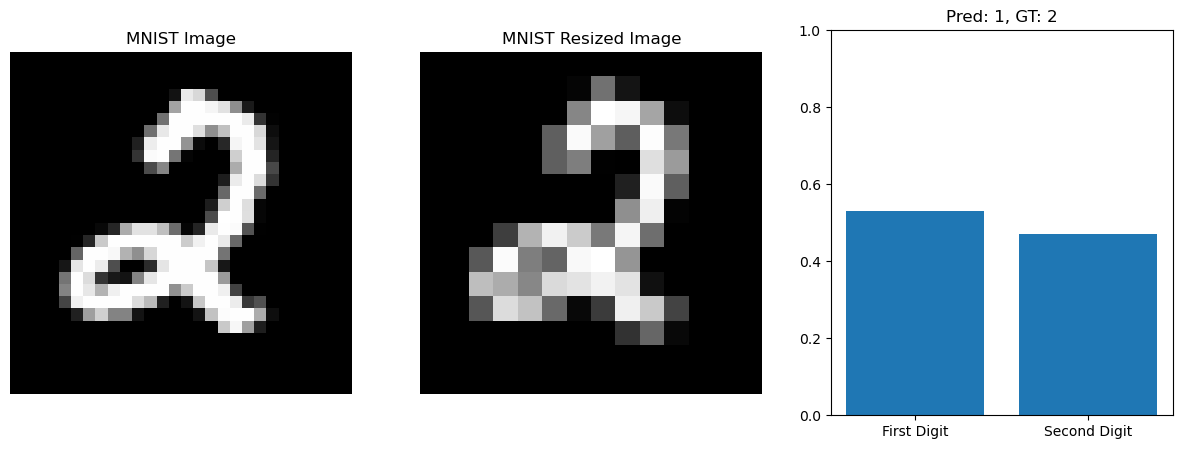

In [95]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_sample = x_test[8880]
y_sample = y_test[8880]

x_sample_resized = cv2.resize(x_sample, (14, 14))

x_sample_spikes = temporal_encoding(x_sample_resized, dt, threshold)

x_sample_flat = x_sample_spikes.reshape(1, -1)

# 01 -> 02 -> 23 -> 24 -> 25 -> 26 -> 27 -> 28 ->29 -> 2
weight_map = np_weights29
prediction = np.dot(x_sample_flat, weight_map)
prediction_normalized = prediction / (1 + prediction)
predicted_label = 1 if prediction_normalized[0, 0] >= 0.5 else 0

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_sample, cmap="gray")
plt.axis("off")
plt.title("MNIST Image")
# plot the resized image
plt.subplot(1, 3, 2)
plt.imshow(x_sample_resized, cmap="gray")
plt.axis("off")
plt.title("MNIST Resized Image")

plt.subplot(1, 3, 3)
plt.bar(["First Digit", "Second Digit"], [prediction_normalized[0, 0], 1 - prediction_normalized[0, 0]])
plt.ylim([0, 1])
plt.title("Pred: {}, GT: {}".format(predicted_label, y_sample))

plt.show()


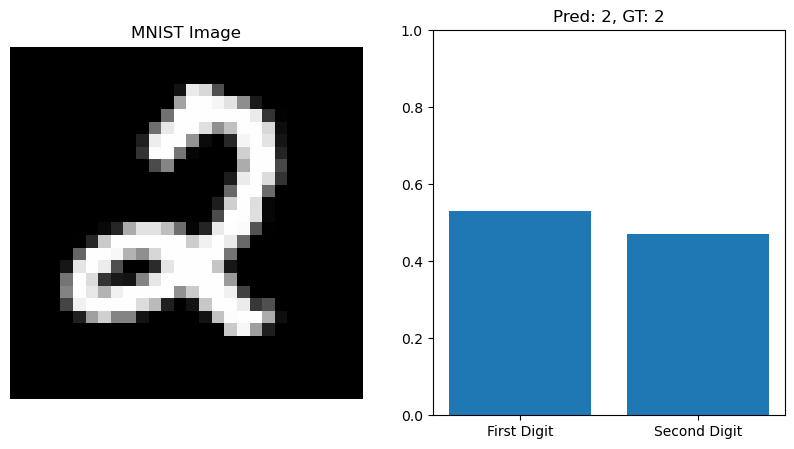

In [104]:
def get_weight_map(current_map_name, outcome):
    if current_map_name is None:
        return "np_weights01"
    
    first_digit, second_digit = int(current_map_name[-2]), int(current_map_name[-1])
    
    if outcome == 1:
        second_digit += 1
    else:
        first_digit  = second_digit
        second_digit = first_digit + 1
    
    if second_digit == 10:
        return None
    
    next_map_name = "np_weights" + str(first_digit) + str(second_digit)
    return next_map_name


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_sample = x_test[8880]
y_sample = y_test[8880]

x_sample_resized = cv2.resize(x_sample, (14, 14))

x_sample_spikes = temporal_encoding(x_sample_resized, dt, threshold)

x_sample_flat = x_sample_spikes.reshape(1, -1)

# 01 -> 02 -> 23 -> 24 -> 25 -> 26 -> 27 -> 28 ->29 -> 2
weight_map_name = None
previous_weight_map_name = None
weight_map = None

while True:
    previous_weight_map_name = weight_map_name
    weight_map_name = get_weight_map(weight_map_name, predicted_label)
    
    if weight_map_name is None:
        break
        
    weight_map = globals()[weight_map_name]
    prediction = np.dot(x_sample_flat, weight_map)
    prediction_normalized = prediction / (1 + prediction)
    predicted_label = 1 if prediction_normalized[0, 0] >= 0.5 else 0

final_digit = int(previous_weight_map_name[-2]) if predicted_label == 1 else int(previous_weight_map_name[-1])
predicted_label = final_digit

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_sample, cmap="gray")
plt.axis("off")
plt.title("MNIST Image")

plt.subplot(1, 2, 2)
plt.bar(["First Digit", "Second Digit"], [prediction_normalized[0, 0], 1 - prediction_normalized[0, 0]])
plt.ylim([0, 1])
plt.title("Pred: {}, GT: {}".format(predicted_label, y_sample))

plt.show()


ODOvO Outcome Driven One vs One

In [105]:
num_correct = 0
for i in range(len(x_test) - 2000, len(x_test)):
    x_sample = x_test[i]
    y_sample = y_test[i]

    x_sample_resized = cv2.resize(x_sample, (14, 14))

    x_sample_spikes = temporal_encoding(x_sample_resized, dt, threshold)

    x_sample_flat = x_sample_spikes.reshape(1, -1)

    weight_map_name = None
    previous_weight_map_name = None
    weight_map = None
    predicted_label = 0

    while True:
        previous_weight_map_name = weight_map_name
        weight_map_name = get_weight_map(weight_map_name, predicted_label)

        if weight_map_name is None:
            break

        weight_map = globals()[weight_map_name]
        prediction = np.dot(x_sample_flat, weight_map)
        prediction_normalized = prediction / (1 + prediction)
        predicted_label = 1 if prediction_normalized[0, 0] >= 0.5 else 0

    final_digit = int(previous_weight_map_name[-2]) if predicted_label == 1 else int(previous_weight_map_name[-1])
    predicted_label = final_digit

    if predicted_label == y_sample:
        num_correct += 1

accuracy = num_correct / 2000
print("Accuracy: {:.2%}".format(accuracy))


Accuracy: 62.65%


Traditional One Vs One

In [100]:
num_correct = 0
for i in range(len(x_test) - 2000, len(x_test)):
    x_sample = x_test[i]
    y_sample = y_test[i]

    x_sample_resized = cv2.resize(x_sample, (14, 14))
    x_sample_spikes = temporal_encoding(x_sample_resized, dt, threshold)
    x_sample_flat = x_sample_spikes.reshape(1, -1)

    votes = [0] * 10
    for i in range(9):
        for j in range(i+1, 10):
            weight_map_name = 'np_weights' + str(i) + str(j)
            weight_map = globals()[weight_map_name]
            prediction = np.dot(x_sample_flat, weight_map)
            prediction_normalized = prediction / (1 + prediction)
            predicted_label = i if prediction_normalized[0, 0] >= 0.5 else j
            votes[predicted_label] += 1

    final_digit = votes.index(max(votes))
    if final_digit == y_sample:
        num_correct += 1

accuracy = num_correct / 2000
print("Accuracy: {:.2%}".format(accuracy))


Accuracy: 63.20%


In [102]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import cv2

def temporal_encoding(image, dt, threshold):
    image = image.astype(np.float64)
    thresholded = image >= threshold
    spikes = thresholded.astype(np.float64)
    return spikes

class SigmoidWeightsLayer:
    def __init__(self, input_dim, output_dim, learning_rate=0.01):
        self.kernel = np.random.uniform(0, 1, (input_dim, output_dim))
        self.bias = np.zeros(output_dim)
        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        positive_weights = self.sigmoid(self.kernel)
        return np.dot(x, positive_weights) + self.bias

    def update_weights(self, x, error):
        sigmoid_weights = self.sigmoid(self.kernel)
        gradient = np.dot(x.T, error)
        weight_update = sigmoid_weights * (1 - sigmoid_weights) * gradient
        self.kernel -= self.learning_rate * weight_update
        self.bias -= self.learning_rate * np.mean(error, axis=0)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

dt = 1
tau = 10
threshold = 20
input_shape = (14, 14)
input_dim = input_shape[0] * input_shape[1]
output_dim = 1
learning_rate = 0.01
epochs = 590
batch_size = 32

x_train_resized = np.array([cv2.resize(img, (14, 14)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (14, 14)) for img in x_test])

x_train_spikes = np.zeros((x_train_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_train_resized.shape[0]):
    x_train_spikes[i] = temporal_encoding(x_train_resized[i], dt, threshold)

x_test_spikes = np.zeros((x_test_resized.shape[0], 14, 14), dtype=np.float64)
for i in range(x_test_resized.shape[0]):
    x_test_spikes[i] = temporal_encoding(x_test_resized[i], dt, threshold)

for class_label in range(10):  # For each class, we train a different classifier
    np.random.seed(0)
    sigmoid_layer = SigmoidWeightsLayer(input_dim, output_dim, learning_rate)

    y_train_binary = np.where(y_train == class_label, 1, 0)
    y_test_binary = np.where(y_test == class_label, 1, 0)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs} for class {class_label}")
        for i in range(0, len(x_train_spikes), batch_size):
            batch_inputs = x_train_spikes[i:i + batch_size]
            batch_labels = y_train_binary[i:i + batch_size]

            batch_inputs_flat = batch_inputs.reshape((batch_inputs.shape[0], -1))
            outputs = sigmoid_layer.forward(batch_inputs_flat)
            error = outputs - batch_labels[:, np.newaxis]

            sigmoid_layer.update_weights(batch_inputs_flat, error)

    correct_predictions = 0
    for inputs, label in zip(x_test_spikes, y_test_binary):
        inputs_flat = inputs.reshape((1, -1))
        output = sigmoid_layer.forward(inputs_flat)
        prediction = int(output > 0.5)
        correct_predictions += int(prediction == label)

    accuracy = correct_predictions / len(x_test_spikes)
    print("Classification accuracy on test set for class {}: {:.2f}%".format(class_label, 100 * accuracy))

    positive_weights = sigmoid_layer.sigmoid(sigmoid_layer.kernel)
    globals()['np_weights' + str(class_label)] = positive_weights


Epoch 1/590 for class 0
Epoch 2/590 for class 0
Epoch 3/590 for class 0
Epoch 4/590 for class 0
Epoch 5/590 for class 0
Epoch 6/590 for class 0
Epoch 7/590 for class 0
Epoch 8/590 for class 0
Epoch 9/590 for class 0
Epoch 10/590 for class 0
Epoch 11/590 for class 0
Epoch 12/590 for class 0
Epoch 13/590 for class 0
Epoch 14/590 for class 0
Epoch 15/590 for class 0
Epoch 16/590 for class 0
Epoch 17/590 for class 0
Epoch 18/590 for class 0
Epoch 19/590 for class 0
Epoch 20/590 for class 0
Epoch 21/590 for class 0
Epoch 22/590 for class 0
Epoch 23/590 for class 0
Epoch 24/590 for class 0
Epoch 25/590 for class 0
Epoch 26/590 for class 0
Epoch 27/590 for class 0
Epoch 28/590 for class 0
Epoch 29/590 for class 0
Epoch 30/590 for class 0
Epoch 31/590 for class 0
Epoch 32/590 for class 0
Epoch 33/590 for class 0
Epoch 34/590 for class 0
Epoch 35/590 for class 0
Epoch 36/590 for class 0
Epoch 37/590 for class 0
Epoch 38/590 for class 0
Epoch 39/590 for class 0
Epoch 40/590 for class 0
Epoch 41/

ONE-VS-REST

In [106]:
num_correct = 0
for i in range(len(x_test) - 2000, len(x_test)):
    x_sample = x_test[i]
    y_sample = y_test[i]

    x_sample_resized = cv2.resize(x_sample, (14, 14))
    x_sample_spikes = temporal_encoding(x_sample_resized, dt, threshold)
    x_sample_flat = x_sample_spikes.reshape(1, -1)

    predictions = []
    for i in range(10):
        weight_map_name = 'np_weights' + str(i)
        weight_map = globals()[weight_map_name]
        prediction = np.dot(x_sample_flat, weight_map)
        prediction_normalized = prediction / (1 + prediction)
        predictions.append(prediction_normalized[0, 0])

    final_digit = predictions.index(max(predictions))
    if final_digit == y_sample:
        num_correct += 1

accuracy = num_correct / 2000
print("Accuracy: {:.2%}".format(accuracy))


Accuracy: 56.15%
